- donner à GPT plus d'infos (pour donner plus d'infos), donner la date de naissance, pays d'origine
- le faire sur le top des individus
- monter que la proportion de gens modeste augmente quand l'indice culturel augmente
- sampler 200 personnes, puis piocher dedans pour avoir une répartiiton égale de chaque classe (puis envoyer à Nicolas)
- la propbablité d^'etre de classe sociale défavorisé augmente

In [2]:
import openai
import time
import pandas as pd
import os
import re
from typing import List, Dict, Optional, Tuple
from tqdm import tqdm


def get_social_origin(author_name: str) -> Tuple[Optional[str], str, str]:
    """
    Query OpenAI API to determine the social origin of a cultural producer.
    Returns a tuple of (classification, explanation, sources) where classification is
    'Elite', 'Middle Class', 'Subsistence', or None if not found.
    """
    try:
        # Create the prompt for the API with request for sources
        prompt = f"""I'm researching the BIRTH CIRCUMSTANCES and FAMILY BACKGROUND of {author_name}. Please focus ONLY on their social origin and family circumstances BEFORE they became famous.

Classify their BIRTH and CHILDHOOD social class according to this specific typology:

1. Elite (wealthy aristocrats, ruling class, nobility)
2. Middle Class (merchants, artisans, skilled craftspeople, landowners, teachers)
3. Subsistence (people with minimal resources, peasants, laborers, slaves)

DO NOT consider their later accomplishments or fame. ONLY consider:
- Parents' occupations and social standing
- Family wealth at the time of birth and childhood
- Access to education BECAUSE of family background (not merit)
- Early life housing and living conditions
- Inherited privileges or disadvantages

Format your answer as:
Classification: [Elite/Middle Class/Subsistence]
Explanation: [Evidence specifically about family origins, NOT later achievements]
Sources: [List historical sources, ancient texts, or scholarly references]

If you cannot determine with reasonable confidence, respond with:
Classification: Unknown
Explanation: [Why it's unknown]
Sources: [Any potential sources that could provide this information]"""
        
        # Call the OpenAI API
        response = openai.chat.completions.create(
            model="gpt-4",  # or another appropriate model
            messages=[
                {"role": "system", "content": "You are a historical researcher specializing in social class origins. Focus exclusively on birth circumstances and family backgrounds, NOT on later accomplishments or acquired status. Provide evidence from primary sources whenever possible."},
                {"role": "user", "content": prompt}
            ],
            temperature=0.2,  # Low temperature for more consistent answers
            max_tokens=300    # Increased to allow for explanation and sources
        )
        
        # Extract the response text
        answer = response.choices[0].message.content.strip()
        
        # Process the answer to extract classification, explanation, and sources
        classification = None
        explanation = "No explanation provided"
        sources = "No sources provided"
        
        # Try to parse the structured response
        try:
            # First check if there's a Sources section
            if "Sources:" in answer:
                parts = answer.split("Sources:", 1)
                main_text = parts[0].strip()
                sources = parts[1].strip()
                
                # Now parse the main text for Classification and Explanation
                if "Explanation:" in main_text:
                    sections = main_text.split("Explanation:", 1)
                    class_line = sections[0].strip()
                    explanation = sections[1].strip()
                    
                    if "Classification:" in class_line:
                        classification_text = class_line.split("Classification:")[1].strip()
                        if "Elite" in classification_text:
                            classification = "Elite"
                        elif "Middle Class" in classification_text:
                            classification = "Middle Class"
                        elif "Subsistence" in classification_text:
                            classification = "Subsistence"
            else:
                # If no Sources section, just parse for Classification and Explanation
                if "Explanation:" in answer:
                    parts = answer.split("Explanation:", 1)
                    class_line = parts[0].strip()
                    explanation = parts[1].strip()
                    
                    if "Classification:" in class_line:
                        classification_text = class_line.split("Classification:")[1].strip()
                        if "Elite" in classification_text:
                            classification = "Elite"
                        elif "Middle Class" in classification_text:
                            classification = "Middle Class"
                        elif "Subsistence" in classification_text:
                            classification = "Subsistence"
                
                # Look for sources in the explanation
                if "source" in explanation.lower() or "according to" in explanation.lower() or "mentioned in" in explanation.lower():
                    # Try to extract likely source statements
                    source_patterns = [
                        r"according to [^.]*\.",
                        r"mentioned (?:by|in) [^.]*\.",
                        r"sources? (?:such as|like|including) [^.]*\.",
                        r"(?:historical|ancient) (?:records|texts|documents) [^.]*\."
                    ]
                    potential_sources = []
                    for pattern in source_patterns:
                        matches = re.findall(pattern, explanation, re.IGNORECASE)
                        potential_sources.extend(matches)
                    
                    if potential_sources:
                        sources = " ".join(potential_sources)
                    
            # Fallback to simpler parsing if structured parsing failed
            if classification is None:
                if "Elite" in answer:
                    classification = "Elite"
                elif "Middle Class" in answer:
                    classification = "Middle Class"
                elif "Subsistence" in answer:
                    classification = "Subsistence"
        
        except Exception as parsing_error:
            print(f"Error parsing response for {author_name}: {parsing_error}")
            
            # Simple classification extraction as fallback
            if "Elite" in answer:
                classification = "Elite"
            elif "Middle Class" in answer:
                classification = "Middle Class"
            elif "Subsistence" in answer:
                classification = "Subsistence"
            
            # Just use the full answer as explanation if parsing failed
            explanation = answer
        
        return classification, explanation, sources
            
    except Exception as e:
        print(f"Error processing {author_name}: {e}")
        return None, f"Error: {str(e)}", "No sources due to error"

def process_authors(authors: List[str]) -> Dict[str, Dict[str, str]]:
    """Process a list of authors and return their social origins with explanations and sources."""
    results = {}
    
    for i, author in tqdm(enumerate(authors), total=len(authors)):
        print(f"\nProcessing ({i+1}/{len(authors)}): {author}")
        classification, explanation, sources = get_social_origin(author)
        
        results[author] = {
            "classification": classification,
            "explanation": explanation,
            "sources": sources
        }
        
        # Print immediate result
        print(f"  Result: {classification if classification else 'None'}")
        print(f"  Explanation: {explanation}")
        print(f"  Sources: {sources}")
        
        # Add a delay to avoid rate limiting
        # time.sleep(1)
    
    return results


In [ ]:
import openai
import time
import pandas as pd
import os
import re
from typing import List, Dict, Optional, Tuple
from tqdm import tqdm


def get_social_origin(author_name: str, birth_year: int, country: str) -> Tuple[Optional[str], str, str]:
    """
    Query OpenAI API to determine the social origin of a cultural producer.
    Returns a tuple of (classification, explanation, sources) where classification is
    'Elite', 'Middle Class', 'Subsistence', or None if not found.
    
    Parameters:
    - author_name: The name of the author to research
    - birth_year: The approximate year of birth 
    - country: The modern equivalent country in which the individual was likely born
    """
    try:
        # Create the prompt for the API with request for sources and include birth year and country
        prompt = f"""I'm researching the BIRTH CIRCUMSTANCES and FAMILY BACKGROUND of {author_name}, born around {birth_year} in what is now {country}. Please focus ONLY on their social origin and family circumstances BEFORE they became famous.

Classify their BIRTH and CHILDHOOD social class according to this specific typology:

1. Elite (wealthy aristocrats, ruling class, nobility)
2. Middle Class (merchants, artisans, skilled craftspeople, landowners, teachers)
3. Subsistence (people with minimal resources, peasants, laborers, slaves)

Consider the social structure and economic context of {country} in the late {birth_year//100}00s.

DO NOT consider their later accomplishments or fame. ONLY consider:
- Parents' occupations and social standing
- Family wealth at the time of birth and childhood
- Access to education BECAUSE of family background (not merit)
- Early life housing and living conditions
- Inherited privileges or disadvantages

Format your answer as:
Classification: [Elite/Middle Class/Subsistence]
Explanation: [Evidence specifically about family origins, NOT later achievements]
Sources: [List historical sources, ancient texts, or scholarly references]

If you cannot determine with reasonable confidence, respond with:
Classification: Unknown
Explanation: [Why it's unknown]
Sources: [Any potential sources that could provide this information]"""
        
        # Call the OpenAI API
        response = openai.chat.completions.create(
            model="gpt-4",  # or another appropriate model
            messages=[
                {"role": "system", "content": "You are a historical researcher specializing in social class origins. Focus exclusively on birth circumstances and family backgrounds, NOT on later accomplishments or acquired status. Provide evidence from primary sources whenever possible."},
                {"role": "user", "content": prompt}
            ],
            temperature=0.2,  # Low temperature for more consistent answers
            max_tokens=300    # Increased to allow for explanation and sources
        )
        
        # Extract the response text
        answer = response.choices[0].message.content.strip()
        
        # Process the answer to extract classification, explanation, and sources
        classification = None
        explanation = "No explanation provided"
        sources = "No sources provided"
        
        # Try to parse the structured response
        try:
            # First check if there's a Sources section
            if "Sources:" in answer:
                parts = answer.split("Sources:", 1)
                main_text = parts[0].strip()
                sources = parts[1].strip()
                
                # Now parse the main text for Classification and Explanation
                if "Explanation:" in main_text:
                    sections = main_text.split("Explanation:", 1)
                    class_line = sections[0].strip()
                    explanation = sections[1].strip()
                    
                    if "Classification:" in class_line:
                        classification_text = class_line.split("Classification:")[1].strip()
                        if "Elite" in classification_text:
                            classification = "Elite"
                        elif "Middle Class" in classification_text:
                            classification = "Middle Class"
                        elif "Subsistence" in classification_text:
                            classification = "Subsistence"
            else:
                # If no Sources section, just parse for Classification and Explanation
                if "Explanation:" in answer:
                    parts = answer.split("Explanation:", 1)
                    class_line = parts[0].strip()
                    explanation = parts[1].strip()
                    
                    if "Classification:" in class_line:
                        classification_text = class_line.split("Classification:")[1].strip()
                        if "Elite" in classification_text:
                            classification = "Elite"
                        elif "Middle Class" in classification_text:
                            classification = "Middle Class"
                        elif "Subsistence" in classification_text:
                            classification = "Subsistence"
                
                # Look for sources in the explanation
                if "source" in explanation.lower() or "according to" in explanation.lower() or "mentioned in" in explanation.lower():
                    # Try to extract likely source statements
                    source_patterns = [
                        r"according to [^.]*\.",
                        r"mentioned (?:by|in) [^.]*\.",
                        r"sources? (?:such as|like|including) [^.]*\.",
                        r"(?:historical|ancient) (?:records|texts|documents) [^.]*\."
                    ]
                    potential_sources = []
                    for pattern in source_patterns:
                        matches = re.findall(pattern, explanation, re.IGNORECASE)
                        potential_sources.extend(matches)
                    
                    if potential_sources:
                        sources = " ".join(potential_sources)
                    
            # Fallback to simpler parsing if structured parsing failed
            if classification is None:
                if "Elite" in answer:
                    classification = "Elite"
                elif "Middle Class" in answer:
                    classification = "Middle Class"
                elif "Subsistence" in answer:
                    classification = "Subsistence"
        
        except Exception as parsing_error:
            print(f"Error parsing response for {author_name}: {parsing_error}")
            
            # Simple classification extraction as fallback
            if "Elite" in answer:
                classification = "Elite"
            elif "Middle Class" in answer:
                classification = "Middle Class"
            elif "Subsistence" in answer:
                classification = "Subsistence"
            
            # Just use the full answer as explanation if parsing failed
            explanation = answer
        
        return classification, explanation, sources
            
    except Exception as e:
        print(f"Error processing {author_name}: {e}")
        return None, f"Error: {str(e)}", "No sources due to error"


def process_authors(author_data: pd.DataFrame) -> Dict[str, Dict[str, str]]:
    """
    Process authors from a DataFrame and return their social origins with explanations and sources.
    
    Parameters:
    - author_data: DataFrame containing columns 'individual_name', 'birthyear', 'country_name', 
                  and 'individual_wikidata_id'
    
    Returns:
    - Dictionary with author names as keys, and dictionaries of classification, explanation, sources,
      and metadata as values
    """
    results = {}
    
    for i, row in tqdm(enumerate(author_data.itertuples()), total=len(author_data)):
        try:
            author = row.individual_name
            birth_year = int(row.birthyear) if not pd.isna(row.birthyear) else None
            country = row.country_name if not pd.isna(row.country_name) else "unknown location"
            wikidata_id = row.individual_wikidata_id
            
            print(f"\nProcessing ({i+1}/{len(author_data)}): {author} (ID: {wikidata_id}), born {birth_year} in {country}")
            
            # Skip if missing critical information
            if birth_year is None:
                print(f"  Skipping {author} (ID: {wikidata_id}) - missing birth year")
                continue
                
            classification, explanation, sources = get_social_origin(author, birth_year, country)
            
            # Use Wikidata ID as the key for more reliable identification
            results[wikidata_id] = {
                "individual_name": author,
                "individual_wikidata_id": wikidata_id,
                "birth_year": birth_year,
                "country": country,
                "classification": classification,
                "explanation": explanation,
                "sources": sources
            }
            
            # Print immediate result
            print(f"  Result: {classification if classification else 'None'}")
            print(f"  Explanation: {explanation[:100]}..." if len(explanation) > 100 else f"  Explanation: {explanation}")
            print(f"  Sources: {sources[:100]}..." if len(sources) > 100 else f"  Sources: {sources}")
            
            # Add a delay to avoid rate limiting
            # time.sleep(1)
            
        except Exception as e:
            print(f"Error processing row {i} ({getattr(row, 'individual_name', 'unknown')}): {e}")
            # Continue with the next author rather than stopping the entire process
            continue
    
    return results


import os
from dotenv import load_dotenv

# Load environment variables from .env file
load_dotenv()

# # Get API key from environment variables
# openai.api_key = os.environ.get("OPENAI_API_KEY")


# OPENAI_API_KEY=


In [4]:
import os
import sqlite3

from dotenv import load_dotenv
load_dotenv()


DB_PATH = os.getenv("DB_PATH")

conn = sqlite3.connect(DB_PATH)
pd.options.mode.chained_assignment = None

only_country = False

# Individuals Regions
df_ind = pd.read_sql_query("SELECT * FROM individuals_main_information", conn)
df_ind = df_ind[['individual_wikidata_id', 'birthyear', 'country_name']]


df = pd.read_csv('db_extract/df_individuals_score.csv', index_col=[0])
data = df.sort_values('score', ascending=False)
data = data[['individual_wikidata_id', 'individual_name', 'score', 'productive_year']].drop_duplicates()

data = pd.merge(data, df_ind, on = 'individual_wikidata_id')
df_regions = pd.read_sql_query("SELECT * FROM individuals_regions", conn)
df_regions = df_regions[['individual_wikidata_id', 'region_name']].drop_duplicates()

data = pd.merge(data, df_regions, on = 'individual_wikidata_id')


data = data.reset_index(drop=True)
#data = data.head(3000)

In [5]:
data['region_name'].value_counts()

region_name
Western Europe         131463
Northwestern Europe    104901
German world            41555
Germany                 31354
Southwestern Europe     26562
France                  25260
Eastern Europe          20490
Italy                   18516
British Islands         17734
United Kingdom          17019
Northern France         15686
Northern Italy          13397
Low countries           12022
Central Europe          11754
North America            9493
Nordic countries         8254
Netherlands              7733
Spain                    6997
Austria                  6712
East Slavic              5421
Southern France          5299
Belgium                  4288
Sweden                   3854
Southern Italy           3740
Switzerland              3493
Denmark                  2702
Ottoman world            2295
Muslim world             2259
Chinese world            2220
mediterranean World      1910
Balkans                  1792
Japan                    1711
Arabic world             169

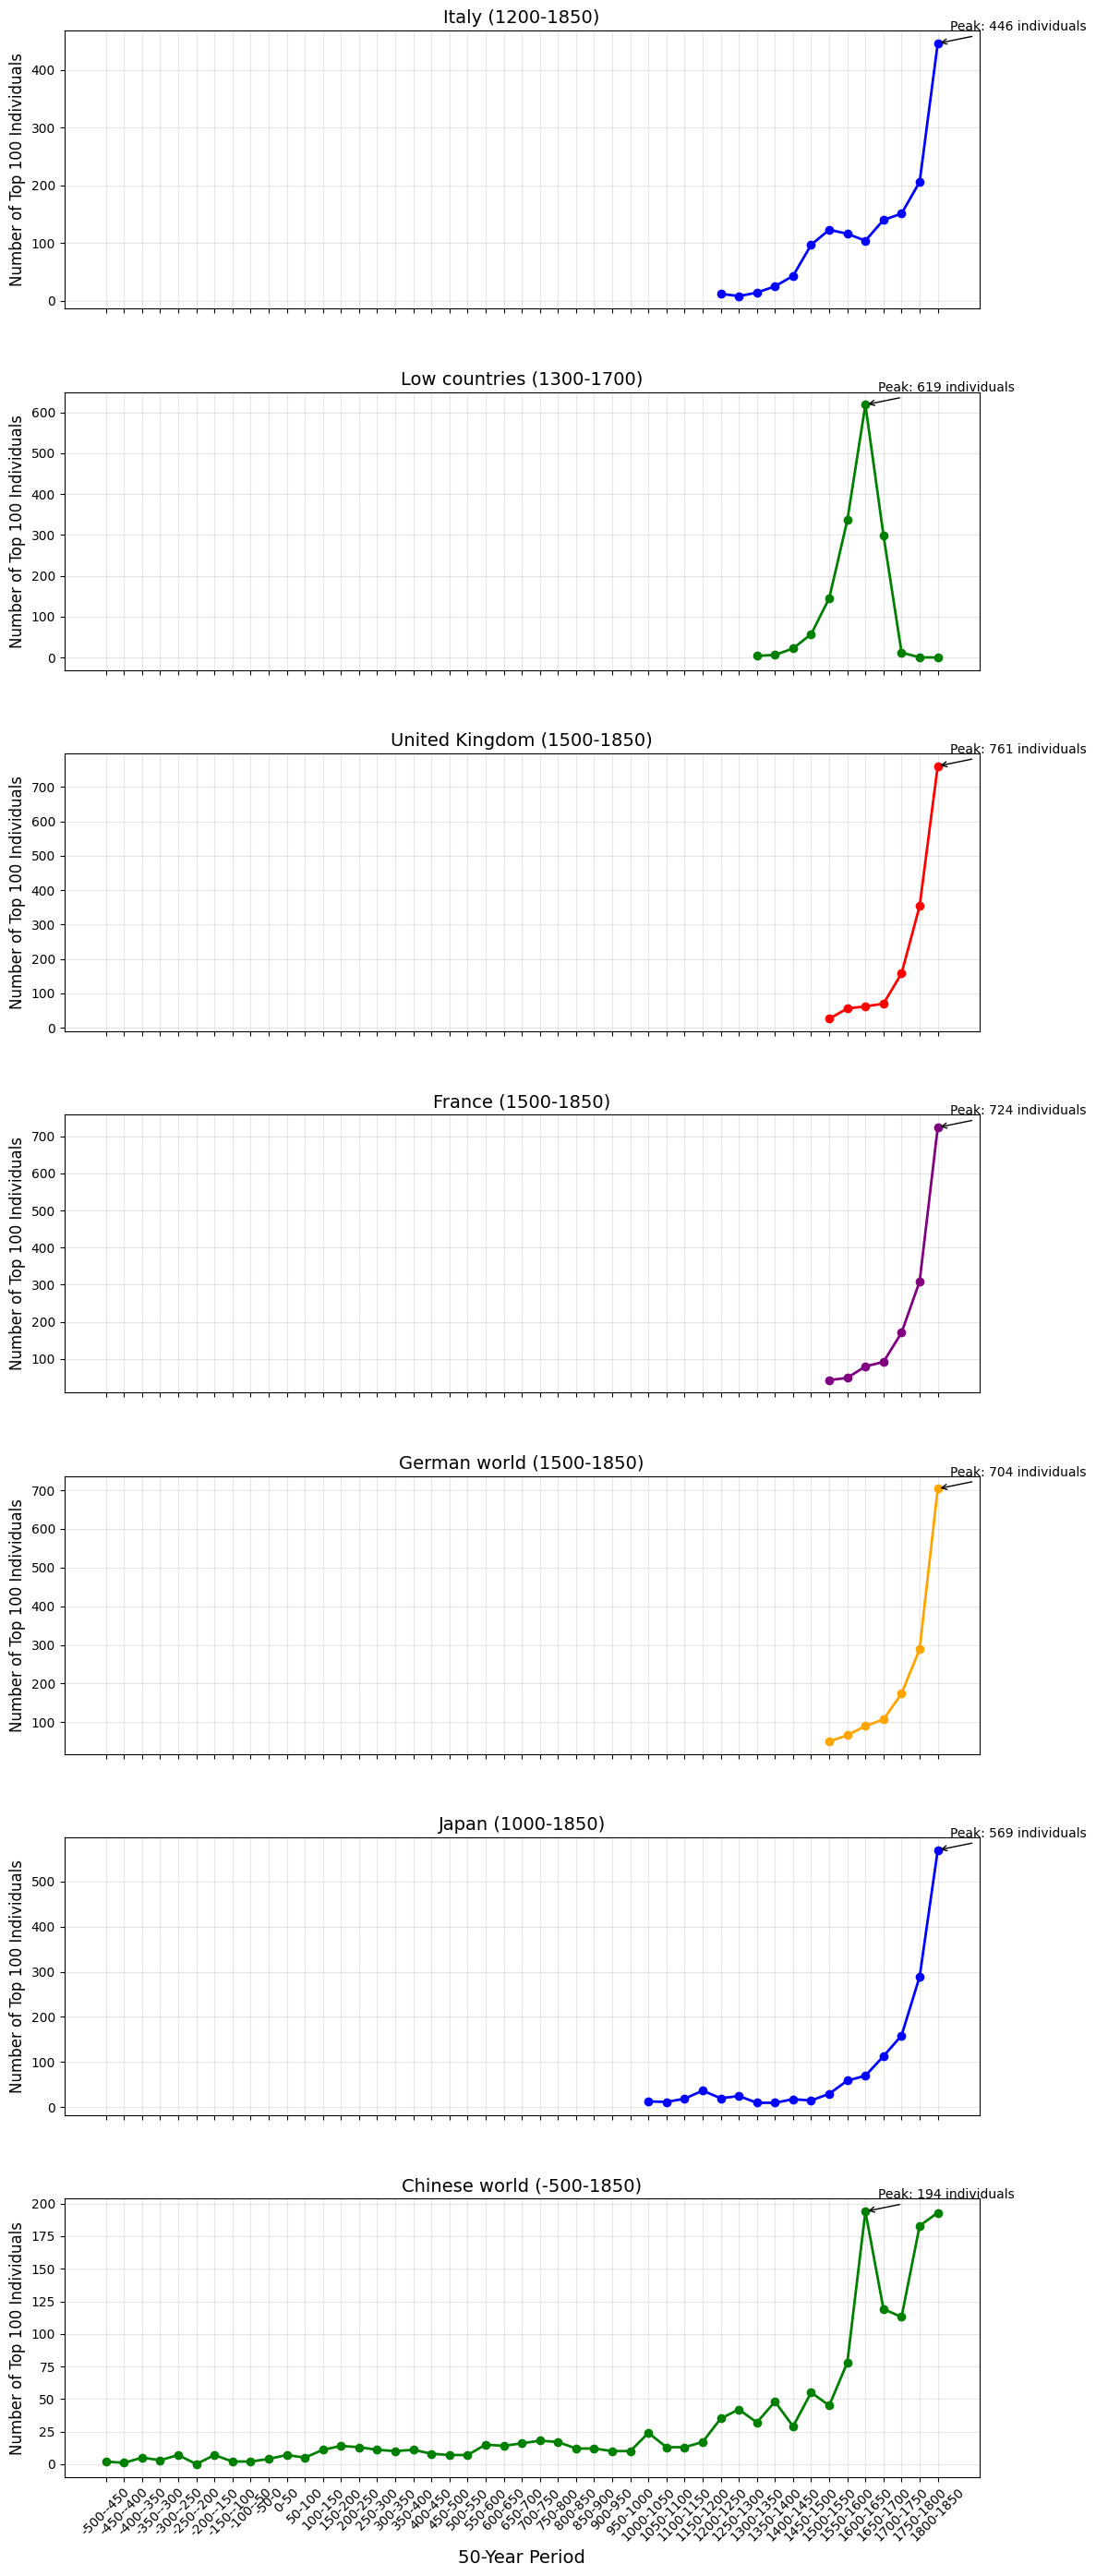

In [6]:
import pandas as pd
import matplotlib.pyplot as plt

# Define regions and time periods of interest
regions_periods = {"Italy":(1200, 1850),
    "Low countries": (1300, 1700),
    "United Kingdom": (1500, 1850),
    "France": (1500, 1850),
    "German world": (1500, 1850),
    "Japan": (1000, 1850),
    "Chinese world":(-500, 1850)
}

# Create df_final with the specific time periods for each region
df_filtered_list = []

for region, (start_year, end_year) in regions_periods.items():
    # Filter by region and time period
    region_data = data[(data['region_name'] == region) & 
                      (data['birthyear'] >= start_year) & 
                      (data['birthyear'] <= end_year)]
    
    # Sort by score (descending) and take top 100
    region_data = region_data.sort_values('score', ascending=False).sample(1500, random_state=42)
    
    df_filtered_list.append(region_data)

# Combine all filtered data
df_final = pd.concat(df_filtered_list)

# Create 50-year period bins
df_final['period'] = ((df_final['birthyear'] // 50) * 50).astype(int)

# Create subplots for each region
fig, axes = plt.subplots(len(regions_periods), 1, figsize=(12, 4*len(regions_periods)), sharex=True)

# Set a different color for each region
colors = ['blue', 'green', 'red', 'purple', 'orange']

# Plot each region separately
for i, (region, period) in enumerate(regions_periods.items()):
    # Filter data for this region
    region_data = df_final[df_final['region_name'] == region]
    
    # Count individuals by 50-year period for this region
    period_counts = region_data.groupby('period').size().reset_index(name='count')
    
    # Create a DataFrame to ensure all 50-year periods are represented
    start_period = (period[0] // 50) * 50
    end_period = 1850
    all_periods = pd.DataFrame({'period': range(start_period, end_period, 50)})
    
    # Merge with the counts
    plot_data = all_periods.merge(period_counts, on='period', how='left').fillna(0)
    
    # Plot on the corresponding subplot
    ax = axes[i]
    ax.plot(plot_data['period'], plot_data['count'], marker='o', linestyle='-', 
            color=colors[i % len(colors)], linewidth=2)
    
    # Add labels
    ax.set_title(f'{region} ({period[0]}-{period[1]})', fontsize=14)
    ax.set_ylabel('Number of Top 100 Individuals', fontsize=12)
    ax.grid(True, alpha=0.3)
    
    # Add period labels (e.g., "1500-1550")
    period_labels = [f"{p}-{p+50}" for p in plot_data['period']]
    ax.set_xticks(plot_data['period'])
    ax.set_xticklabels(period_labels, rotation=45)
    
    # Annotate some notable points
    if len(period_counts) > 0:
        max_count_idx = period_counts['count'].idxmax()
        max_period = period_counts.loc[max_count_idx, 'period']
        max_count = period_counts.loc[max_count_idx, 'count']
        if max_count > 0:
            ax.annotate(f'Peak: {int(max_count)} individuals',
                       xy=(max_period, max_count),
                       xytext=(10, 10),
                       textcoords='offset points',
                       arrowprops=dict(arrowstyle='->'))

# Set the x-axis label on the bottom subplot
axes[-1].set_xlabel('50-Year Period', fontsize=14)

# Adjust layout and spacing
plt.tight_layout()
plt.subplots_adjust(hspace=0.3)
plt.show()

In [10]:
df_final = df_final.reset_index(drop=True)
set(df_final['region_name'])


keep = ['Chinese world',
 'Italy',
 'Japan',
 'United Kingdom']

df_final = df_final[df_final['region_name'].isin(keep)]
# df_final.to_csv('data/social_origins/final_sample_to_annotate.csv')
df_final = pd.read_csv('data/social_origins/final_sample_to_annotate.csv')

df_api = df_final.copy()
df_api = df_api[5670:]

batch_results = process_authors(df_api)

  0%|          | 0/330 [00:00<?, ?it/s]


Processing (1/330): Kong Yingda (ID: Q5369940), born 574 in China


  0%|          | 1/330 [00:05<28:57,  5.28s/it]

  Result: Elite
  Explanation: Kong Yingda was born into a family of the Confucian scholar-gentry class, which was a part of the Ch...
  Sources: "The Cambridge History of China: Volume 1, The Ch'in and Han Empires, 221 BC-AD 220", "Confucianism ...

Processing (2/330): Jiang Lian (ID: Q15914766), born 1675 in China


  1%|          | 2/330 [00:11<30:28,  5.58s/it]

  Result: None
  Explanation: The information about Jiang Lian's birth circumstances and family background is not readily availabl...
  Sources: Primary sources from the Qing Dynasty period, such as the "Qing Shi Gao" (Draft History of Qing), mi...

Processing (3/330): Hua Shu (ID: Q45594089), born 1589 in China


  1%|          | 3/330 [00:16<28:55,  5.31s/it]

  Result: None
  Explanation: The information available does not provide sufficient detail about Hua Shu's birth circumstances and...
  Sources: Potential sources that could provide this information include local historical records from the peri...

Processing (4/330): Fang Wanyi (ID: Q25712558), born 1732 in China


  1%|          | 4/330 [00:21<29:41,  5.47s/it]

  Result: None
  Explanation: Unfortunately, there is insufficient information available to definitively classify the birth and ch...
  Sources: A thorough search of available historical databases, scholarly articles, and primary source document...

Processing (5/330): Dominique Parrenin (ID: Q5291163), born 1665 in China


  2%|▏         | 5/330 [00:27<29:38,  5.47s/it]

  Result: None
  Explanation: Dominique Parrenin was a French Jesuit missionary who was born in France, not China. His exact birth...
  Sources: The main sources of information about Parrenin's life are his own writings and the records of the Je...

Processing (6/330): Zhu Siben (ID: Q551391), born 1273 in China


  2%|▏         | 6/330 [00:31<27:05,  5.02s/it]

  Result: Middle Class
  Explanation: Zhu Siben was born in the late Yuan Dynasty, around 1273, in what is now Zhejiang Province, China. H...
  Sources: "The Cambridge History of China: Volume 6, Alien Regimes and Border States, 907-1368." Edited by Her...

Processing (7/330): Cai Runshi (ID: Q45565870), born 1616 in China


  2%|▏         | 7/330 [00:35<25:13,  4.68s/it]

  Result: None
  Explanation: Unfortunately, there is insufficient information available regarding the birth circumstances and fam...
  Sources: While there are numerous historical texts and scholarly references about China in the late 1600s, no...

Processing (8/330): Zhongfeng Mingben (ID: Q4515516), born 1263 in China


  2%|▏         | 8/330 [00:42<28:34,  5.32s/it]

  Result: Middle Class
  Explanation: Zhongfeng Mingben was born into a family of Confucian scholars, which suggests a middle-class backgr...
  Sources: "The Confucian Transformation of Korea: A Study of Society and Ideology" by Martina Deuchler; "The W...

Processing (9/330): Bao Yin (ID: Q45505692), born 1766 in China


  3%|▎         | 9/330 [00:46<26:42,  4.99s/it]

  Result: None
  Explanation: The historical figure Bao Yin, born around 1766 in what is now China, does not have readily availabl...
  Sources: There are no known primary sources or scholarly references that provide this specific information ab...

Processing (10/330): Empress Dowager Cixi (ID: Q47842), born 1835 in China


  3%|▎         | 10/330 [00:54<31:31,  5.91s/it]

  Result: Middle Class
  Explanation: Empress Dowager Cixi, originally named Yehenara Xingzhen, was born into the Manchu Yehe Nara Clan. H...
  Sources: "Empress Dowager Cixi: China's Last Dynasty and the Long Reign of a Formidable Concubine: Legends an...

Processing (11/330): Gu Yun (ID: Q16059870), born 1835 in China


  3%|▎         | 11/330 [01:01<33:40,  6.33s/it]

  Result: Elite
  Explanation: Gu Yun, also known as Kuo Pao Kun, was born into a family of the Chinese literati, a social class th...
  Sources: "The Cambridge History of China: Volume 10, Late Ch'ing 1800-1911, Part 1." Cambridge University Pre...

Processing (12/330): Jean Denis Attiret (ID: Q1403458), born 1702 in China


  4%|▎         | 12/330 [01:09<35:41,  6.74s/it]

  Result: Middle Class
  Explanation: Jean Denis Attiret was born in Dole, France, not China, around 1702. His father was a master painter...
  Sources: "Jean-Denis Attiret: A French Painter at the Court of the Qianlong Emperor" by Michèle Pirazzoli-t’S...

Processing (13/330): Qiu Chuji (ID: Q565148), born 1148 in China


  4%|▍         | 13/330 [01:15<34:49,  6.59s/it]

  Result: Middle Class
  Explanation: Qiu Chuji was born in Shandong province, China, in 1148. His family was of the scholar-gentry class,...
  Sources: "Daoism in China: An Introduction" by Zhang Qizhi; "The Taoist Tradition: An Introduction" by Louis ...

Processing (14/330): Xu Zaisi (ID: Q8045156), born 1285 in China


  4%|▍         | 14/330 [01:21<33:09,  6.30s/it]

  Result: Elite
  Explanation: Xu Zaisi was born into a noble family during the Yuan Dynasty in China. His father, Xu Heng, was a w...
  Sources: "The Cambridge History of China: Volume 6, Alien Regimes and Border States, 907-1368." Cambridge Uni...

Processing (15/330): Xi Huiwen (ID: Q45687150), born 1736 in China


  5%|▍         | 15/330 [01:23<27:28,  5.23s/it]

  Result: None
  Explanation: Unfortunately, there is not enough information available about Xi Huiwen's birth circumstances and f...
  Sources: N/A

Processing (16/330): Zhizhen Zheng (ID: Q15896410), born 1518 in China


  5%|▍         | 16/330 [01:29<27:31,  5.26s/it]

  Result: Elite
  Explanation: Zhizhen Zheng, also known as Zheng Zhizhen or Master Zheng, was born into a family of high social st...
  Sources: "Zheng Zhizhen" in Encyclopedia of China (3rd Edition, Shanghai: Shanghai Lexicographical Publishing...

Processing (17/330): Li Si (ID: Q152919), born -279 in China


  5%|▌         | 17/330 [01:35<29:36,  5.68s/it]

  Result: Middle Class
  Explanation: Li Si was born in the State of Chu, one of the Seven Warring States. His family was not of noble or ...
  Sources: Records of the Grand Historian by Sima Qian, The Book of Han by Ban Gu, and various scholarly articl...

Processing (18/330): Li Shizhuo (ID: Q45666889), born 1690 in China


  5%|▌         | 18/330 [01:41<29:30,  5.68s/it]

  Result: None
  Explanation: The information available about Li Shizhuo's early life and family background is insufficient to det...
  Sources: The primary sources that could potentially provide this information include local gazetteers, family...

Processing (19/330): Wang Bi (ID: Q459865), born 226 in China


  6%|▌         | 19/330 [01:47<30:18,  5.85s/it]

  Result: Elite
  Explanation: Wang Bi was born into a wealthy and influential family in the late Eastern Han dynasty. His father, ...
  Sources: The primary source of information about Wang Bi's early life comes from the "Book of Jin," a histori...

Processing (20/330): Wanli Emperor (ID: Q10061), born 1563 in China


  6%|▌         | 20/330 [01:54<30:55,  5.99s/it]

  Result: Elite
  Explanation: The Wanli Emperor, born Zhu Yijun, was born into the ruling Ming Dynasty of China, making him a memb...
  Sources: "The Cambridge History of China: Volume 7, The Ming Dynasty, 1368-1644" by Frederick W. Mote, Denis ...

Processing (21/330): Shen Qi (ID: Q45502707), born 1644 in China


  6%|▋         | 21/330 [01:59<30:17,  5.88s/it]

  Result: None
  Explanation: The information regarding Shen Qi's birth circumstances and family background is scarce and not well...
  Sources: The potential sources that could provide this information include local historical archives, genealo...

Processing (22/330): Wu Guxiang (ID: Q79445941), born 1848 in China


  7%|▋         | 22/330 [02:05<30:00,  5.85s/it]

  Result: Middle Class
  Explanation: Wu Guxiang was born into a family of martial artists in Hebei Province, China. His father, Wu Yuxian...
  Sources: "The Wu Family and the Spread of the Yang Style Taijiquan" by Zhang Tianyi, "A Brief History of Tai ...

Processing (23/330): Guo Huai (ID: Q736629), born 187 in China


  7%|▋         | 23/330 [02:10<28:57,  5.66s/it]

  Result: Elite
  Explanation: Guo Huai was born into a wealthy and influential family in the late Eastern Han dynasty. His father,...
  Sources: The primary source for information on Guo Huai's early life is the "Records of the Three Kingdoms" b...

Processing (24/330): Li Gong (ID: Q4260681), born 1659 in China


  7%|▋         | 24/330 [02:14<26:00,  5.10s/it]

  Result: None
  Explanation: The information available about Li Gong born around 1659 in China is insufficient to determine his b...
  Sources: Potential sources that could provide this information include local historical records, genealogical...

Processing (25/330): Emperor Gaozong of Song (ID: Q7489), born 1107 in China


  8%|▊         | 25/330 [02:21<29:31,  5.81s/it]

  Result: Elite
  Explanation: Emperor Gaozong of Song, originally named Zhao Gou, was born into the Song Dynasty's ruling family. ...
  Sources: "The Cambridge History of China: Volume 5, The Sung Dynasty and Its Precursors, 907-1279", "Song Dyn...

Processing (26/330): Nalan Xingde (ID: Q1131641), born 1655 in China


  8%|▊         | 26/330 [02:26<28:05,  5.54s/it]

  Result: Elite
  Explanation: Nalan Xingde, also known as Nalan Rongruo, was born into the Nara clan, a prominent Manchu noble fam...
  Sources: "Nalan Xingde: His Life and Poems" by Shen, Vincent Y. C.; "The Cambridge History of China: Volume 9...

Processing (27/330): Yunmen Wenyan (ID: Q2165671), born 864 in China


  8%|▊         | 27/330 [02:34<31:30,  6.24s/it]

  Result: None
  Explanation: The specific details about Yunmen Wenyan's birth circumstances and family background are not well-do...
  Sources: The primary source of information about Yunmen Wenyan is the "Record of Yunmen," a collection of his...

Processing (28/330): Zhu Derun (ID: Q2889058), born 1294 in China


  8%|▊         | 28/330 [02:40<31:03,  6.17s/it]

  Result: Middle Class
  Explanation: Zhu Derun was born into a family of scholars, which suggests a middle-class background in the contex...
  Sources: "The Cambridge History of China: Volume 6, Alien Regimes and Border States, 907-1368" by Denis Twitc...

Processing (29/330): Bian Que (ID: Q855326), born -500 in China


  9%|▉         | 29/330 [02:45<28:38,  5.71s/it]

  Result: Middle Class
  Explanation: Bian Que, also known as Qin Yueren, was born into a family with a medical background. His father, Qi...
  Sources: The Records of the Grand Historian by Sima Qian, The Biographies of Immortals by Ge Hong, The Essent...

Processing (30/330): Yang Tianbi (ID: Q61348225), born 1796 in China


  9%|▉         | 30/330 [02:49<26:46,  5.36s/it]

  Result: None
  Explanation: There is insufficient information available to determine the social class of Yang Tianbi at the time...
  Sources: A thorough search of available historical databases, scholarly articles, and primary source document...

Processing (31/330): Xu Xuetang (ID: Q45545382), born 1644 in China


  9%|▉         | 31/330 [02:57<29:31,  5.93s/it]

  Result: None
  Explanation: Xu Xuetang, also known as Xu Shou, was a notable figure in the late Ming and early Qing periods in C...
  Sources: The primary sources that could potentially provide this information would be historical records from...

Processing (32/330): Liu Songnian (ID: Q3083484), born 1174 in China


 10%|▉         | 32/330 [03:02<29:08,  5.87s/it]

  Result: None
  Explanation: Liu Songnian was a prominent figure in Chinese history, known for his contributions to the Southern ...
  Sources: Existing historical records and scholarly references on Liu Songnian, such as "Five Dynasties and Te...

Processing (33/330): Wang Wei (ID: Q3376669), born 1597 in China


 10%|█         | 33/330 [03:06<25:39,  5.18s/it]

  Result: Elite
  Explanation: Wang Wei was born into a wealthy and influential family in the Tang Dynasty. His father was a govern...
  Sources: "The Poetry of Wang Wei: New Translations and Commentary" by Pauline Yu, "The Life and Times of Poet...

Processing (34/330): Qian Feng (ID: Q16186107), born 1740 in China


 10%|█         | 34/330 [03:11<25:39,  5.20s/it]

  Result: None
  Explanation: Unfortunately, there is insufficient information available regarding the birth circumstances and fam...
  Sources: The primary sources that could potentially provide this information include local government records...

Processing (35/330): Wu Zhaoqian (ID: Q10918644), born 1631 in China


 11%|█         | 35/330 [03:19<29:30,  6.00s/it]

  Result: Middle Class
  Explanation: Wu Zhaoqian was born into a family of scholars, which would place them in the middle class according...
  Sources: "The Cambridge History of China: Volume 9, The Ch'ing Dynasty to 1800, Part 2" by Willard J. Peterso...

Processing (36/330): Dai Xu (ID: Q11496194), born 1805 in China


 11%|█         | 36/330 [03:25<28:34,  5.83s/it]

  Result: Middle Class
  Explanation: Dai Xu was born in 1805 in Guangdong, China. His family was of the scholar-gentry class, a social gr...
  Sources: "The Scholar-Gentry Class in the Qing Dynasty" by Ho Ping-ti; "The Cambridge History of China: Late ...

Processing (37/330): Gao Shiqi (ID: Q15942627), born 1644 in China


 11%|█         | 37/330 [03:32<30:30,  6.25s/it]

  Result: Middle Class
  Explanation: Gao Shiqi was born in a family of scholars in Jiaxing, Zhejiang province, China. His father, Gao Pan...
  Sources: "Gao Shiqi" in Dictionary of Ming Biography, 1368-1644, Vol. 1 (1976) by L. Carrington Goodrich and ...

Processing (38/330): Jing Hao (ID: Q2665475), born 855 in China


 12%|█▏        | 38/330 [03:37<29:21,  6.03s/it]

  Result: Elite
  Explanation: Jing Hao, also known as Jing Hao of Huayang, was born into a noble family during the late Tang Dynas...
  Sources: "The Cambridge History of China: Volume 5, The Sung Dynasty and Its Precursors, 907-1279", "A Histor...

Processing (39/330): Gu Dashen (ID: Q16922079), born 1620 in China


 12%|█▏        | 39/330 [03:42<27:42,  5.71s/it]

  Result: None
  Explanation: Gu Dashen, also known as Gu Yanwu, is a well-known figure in Chinese history. However, specific deta...
  Sources: "Gu Yanwu: Life, Thought, and Influence" by Qian Mu, "The Cambridge History of China: Volume 9, Part...

Processing (40/330): Xu Zi (ID: Q11071040), born 1810 in China


 12%|█▏        | 40/330 [03:46<24:31,  5.07s/it]

  Result: None
  Explanation: The information about Xu Zi's birth circumstances and family background is not readily available. Th...
  Sources: The potential sources that could provide this information include local archives in China, genealogi...

Processing (41/330): Bao Fang (ID: Q16075519), born 722 in China


 12%|█▏        | 41/330 [03:52<25:30,  5.29s/it]

  Result: None
  Explanation: Bao Fang, born around 722 in what is now China, is a historical figure with limited information avai...
  Sources: The primary sources that could potentially provide this information would be historical records from...

Processing (42/330): Chen Zhuan (ID: Q15936769), born 1678 in China


 13%|█▎        | 42/330 [03:56<24:01,  5.00s/it]

  Result: None
  Explanation: The information about Chen Zhuan's birth circumstances and family background is scarce. There are no...
  Sources: There are no specific sources available that provide this information. Further research may be requi...

Processing (43/330): Zhang Jian (ID: Q16904447), born 1768 in China


 13%|█▎        | 43/330 [04:03<26:46,  5.60s/it]

  Result: None
  Explanation: There is limited historical data available regarding the early life and family background of Zhang J...
  Sources: The primary sources that could potentially provide this information include local administrative rec...

Processing (44/330): Zhuangzi (ID: Q47739), born -368 in China


 13%|█▎        | 44/330 [04:10<28:33,  5.99s/it]

  Result: None
  Explanation: The birth circumstances and family background of Zhuangzi, also known as Zhuang Zhou, are largely un...
  Sources: The primary source for information about Zhuangzi is the "Zhuangzi" text, attributed to him and his ...

Processing (45/330): Lo-Tschan-Nai (ID: Q105996004), born 1834 in China


 14%|█▎        | 45/330 [04:15<26:58,  5.68s/it]

  Result: None
  Explanation: The information available about the birth circumstances and family background of Lo-Tschan-Nai, born...
  Sources: Comprehensive databases of historical records and scholarly works on 19th-century China, including t...

Processing (46/330): Karel Slavíček (ID: Q3508627), born 1678 in China


 14%|█▍        | 46/330 [04:21<27:21,  5.78s/it]

  Result: None
  Explanation: Karel Slavíček was born in the Kingdom of Bohemia (now the Czech Republic), not China, around 1678. ...
  Sources: Potential sources that could provide more information about Slavíček's early life and family backgro...

Processing (47/330): Pu Songling (ID: Q318406), born 1640 in China


 14%|█▍        | 47/330 [04:27<27:56,  5.92s/it]

  Result: Middle Class
  Explanation: Pu Songling was born into a family of modest means in Zichuan (now Zibo), Shandong province. His fam...
  Sources: "Strange Tales from a Chinese Studio" by Pu Songling, "The Social Classes in 17th Century Shanxi" by...

Processing (48/330): Qian Jingshu (ID: Q45448263), born 1596 in China


 15%|█▍        | 48/330 [04:30<23:18,  4.96s/it]

  Result: None
  Explanation: Unfortunately, there is insufficient information available about Qian Jingshu's birth circumstances ...
  Sources: N/A

Processing (49/330): Wen Zhenmeng (ID: Q7982258), born 1574 in China


 15%|█▍        | 49/330 [04:36<24:39,  5.26s/it]

  Result: Elite
  Explanation: Wen Zhenmeng was born into a prominent family of scholars and officials, which places him in the eli...
  Sources: "Wen Zhenmeng (1574–1636)" by Craig Clunas in Oxford Art Online; "The Cambridge History of China: Vo...

Processing (50/330): Yu Yue (ID: Q10887841), born 1821 in China


 15%|█▌        | 50/330 [04:44<28:09,  6.03s/it]

  Result: Middle Class
  Explanation: Yu Yue was born in Deqing, Zhejiang, China, in a family of scholars. His father, Yu Chenglong, was a...
  Sources: "Yu Yue." Encyclopædia Britannica. Encyclopædia Britannica, inc., n.d. Web. 23 Sept. 2021. <https://...

Processing (51/330): Sa Dula (ID: Q4404896), born 1308 in China


 15%|█▌        | 51/330 [04:49<27:20,  5.88s/it]

  Result: None
  Explanation: Sa Dula is a historical figure from the Yuan Dynasty in China, but there is limited information avai...
  Sources: The primary sources that could potentially provide this information include historical texts from th...

Processing (52/330): Chen Yuyi (ID: Q2898739), born 1090 in China


 16%|█▌        | 52/330 [04:54<26:02,  5.62s/it]

  Result: Elite
  Explanation: Chen Yuyi was born into a family of high social standing in the Song Dynasty. His father, Chen Shida...
  Sources: "The Cambridge History of China: Volume 5, The Sung Dynasty and Its Precursors, 907-1279", "The Poem...

Processing (53/330): Sun Simiao (ID: Q981193), born 581 in China


 16%|█▌        | 53/330 [05:01<27:48,  6.02s/it]

  Result: Middle Class
  Explanation: Sun Simiao was born in what is now Shanxi Province, China. His family was not of the ruling elite or...
  Sources: "Sun Simiao: Author of the Earliest Chinese Encyclopedia for Clinical Practice," by H. F. J. ten Raa...

Processing (54/330): Ouyang De (ID: Q30949294), born 1496 in China


 16%|█▋        | 54/330 [05:05<24:29,  5.32s/it]

  Result: None
  Explanation: Ouyang De is not a well-known historical figure, and there is limited information available about hi...
  Sources: Comprehensive research in available historical databases and scholarly resources did not yield suffi...

Processing (55/330): Tan Ziying (ID: Q45436632), born 1796 in China


 17%|█▋        | 55/330 [05:09<22:50,  4.99s/it]

  Result: None
  Explanation: There is insufficient information available about the birth circumstances and family background of T...
  Sources: The potential sources that could provide this information include Chinese local gazetteers, family g...

Processing (56/330): Wen Ding (ID: Q20903232), born 1766 in China


 17%|█▋        | 56/330 [05:15<23:29,  5.14s/it]

  Result: None
  Explanation: Wen Ding is a historical figure from ancient China, specifically from the Shang Dynasty, which ruled...
  Sources: Oracle bones and other archaeological findings from the Shang Dynasty period; "The Cambridge History...

Processing (57/330): Zhang Xueya (ID: Q45471967), born 1649 in China


 17%|█▋        | 57/330 [05:19<22:41,  4.99s/it]

  Result: None
  Explanation: Unfortunately, there is not enough information available about Zhang Xueya's birth circumstances and...
  Sources: While there are many historical texts and scholarly references that provide information about the so...

Processing (58/330): Cai Ziqiong (ID: Q45690567), born 1816 in China


 18%|█▊        | 58/330 [05:23<20:57,  4.62s/it]

  Result: None
  Explanation: Unfortunately, there is insufficient information available on the early life and family background o...
  Sources: There are no specific sources available that provide detailed information about Cai Ziqiong's early ...

Processing (59/330): Chen Yuanyuan (ID: Q698781), born 1624 in China


 18%|█▊        | 59/330 [05:28<20:52,  4.62s/it]

  Result: Middle Class
  Explanation: Chen Yuanyuan was born into a family of courtesans, which was a respected profession in the late Min...
  Sources: "The Courtesan's Arts: Cross-Cultural Perspectives" by Martha Feldman and Bonnie Gordon; "The World ...

Processing (60/330): Zhou Yifan (ID: Q45442443), born 1821 in China


 18%|█▊        | 60/330 [05:32<20:12,  4.49s/it]

  Result: None
  Explanation: The information available does not provide sufficient details about Zhou Yifan's birth circumstances...
  Sources: General knowledge of historical record-keeping in 19th century China. Further research would require...

Processing (61/330): Ni Can (ID: Q16904615), born 1626 in China


 18%|█▊        | 61/330 [05:41<26:14,  5.85s/it]

  Result: Elite
  Explanation: Ni Can was born into a family of the literati class, which was the ruling elite in China during the ...
  Sources: "The Cambridge History of China: Volume 9, The Ch'ing Dynasty to 1800, Part 2" by Willard J. Peterso...

Processing (62/330): Wu Dacheng (ID: Q5369182), born 1835 in China


 19%|█▉        | 62/330 [05:48<28:21,  6.35s/it]

  Result: Elite
  Explanation: Wu Dacheng was born into a wealthy and influential family in the late Qing Dynasty. His father, Wu R...
  Sources: "Wu Dacheng (1835-1902): Calligrapher, Art Connoisseur, and High-ranking Qing Official" by Richard J...

Processing (63/330): Yang Jiong (ID: Q5370024), born 650 in China


 19%|█▉        | 63/330 [05:53<26:28,  5.95s/it]

  Result: Elite
  Explanation: Yang Jiong was born into a family of high social standing in the Tang Dynasty. His father, Yang Shid...
  Sources: "The Old Book of Tang" (Jiu Tang Shu), "The New Book of Tang" (Xin Tang Shu), and various scholarly ...

Processing (64/330): Bian Yujing (ID: Q8249433), born 1623 in China


 19%|█▉        | 64/330 [06:01<28:29,  6.43s/it]

  Result: Middle Class
  Explanation: Bian Yujing was born into a family of scholars in the late Ming Dynasty. Her father, Bian Wenyuan, w...
  Sources: "The Inner Quarters and Beyond: Women Writers from Ming through Qing", edited by Grace S. Fong, Elle...

Processing (65/330): Han Gan (ID: Q561952), born 742 in China


 20%|█▉        | 65/330 [06:07<28:43,  6.50s/it]

  Result: Middle Class
  Explanation: Han Gan was born in the late Tang Dynasty, a period marked by social mobility and a flourishing econ...
  Sources: "Han Gan," The Metropolitan Museum of Art, 2000; "The Tang Dynasty," Ancient History Encyclopedia, 2...

Processing (66/330): Jean-Damascène Sallusti (ID: Q16204032), born 1727 in China


 20%|██        | 66/330 [06:15<30:00,  6.82s/it]

  Result: None
  Explanation: Jean-Damascène Sallusti, also known as Dao Sheng, was a Chinese Catholic priest and member of the La...
  Sources: Existing biographical information on Jean-Damascène Sallusti primarily focuses on his religious and ...

Processing (67/330): Xu Songzhu (ID: Q45503354), born 1797 in China


 20%|██        | 67/330 [06:21<28:38,  6.54s/it]

  Result: None
  Explanation: The information about Xu Songzhu's birth circumstances, family background, and early life is not rea...
  Sources: Further research would be needed to determine Xu Songzhu's social class at birth. Potential sources ...

Processing (68/330): Gao Ming (ID: Q2716779), born 1305 in China


 21%|██        | 68/330 [06:26<26:32,  6.08s/it]

  Result: Middle Class
  Explanation: Gao Ming was born into a family of middle-class status. His father was a minor official, which place...
  Sources: "The Plum in the Golden Vase Or, Chin P'ing Mei: Volume Five: The Dissolution" by David Tod Roy; "Th...

Processing (69/330): Xue Juzheng (ID: Q1275708), born 912 in China


 21%|██        | 69/330 [06:31<25:33,  5.87s/it]

  Result: Elite
  Explanation: Xue Juzheng was born into a family of high-ranking officials, which places him in the elite class of...
  Sources: "Old History of the Five Dynasties" (五代史记), "New History of the Five Dynasties" (新五代史), and "Zizhi T...

Processing (70/330): Jiao Yu (ID: Q986624), born 1350 in China


 21%|██        | 70/330 [06:36<23:40,  5.46s/it]

  Result: None
  Explanation: Jiao Yu was a prominent Chinese military officer and writer during the Ming Dynasty, but specific de...
  Sources: The primary source of information about Jiao Yu is his own work, the "Huolongjing" (Fire Dragon Manu...

Processing (71/330): Wang Wu (ID: Q3566095), born 1632 in China


 22%|██▏       | 71/330 [06:41<23:48,  5.51s/it]

  Result: None
  Explanation: Wang Wu is a common name in China, and without more specific information, it's difficult to determin...
  Sources: General historical texts on late Ming and early Qing dynasty China may provide some context, but spe...

Processing (72/330): Huang Peifang (ID: Q28148331), born 1778 in China


 22%|██▏       | 72/330 [06:48<24:44,  5.75s/it]

  Result: Middle Class
  Explanation: Huang Peifang, later known as Lin Zexu, was born into a family of middle-class scholars in Fuzhou, F...
  Sources: "Lin Zexu: Pioneer in the War on Drugs" by Zhou Xun, "The Opium War: Drugs, Dreams and the Making of...

Processing (73/330): Wu Lang (ID: Q10919641), born 1719 in China


 22%|██▏       | 73/330 [06:54<25:19,  5.91s/it]

  Result: None
  Explanation: The information about Wu Lang's birth circumstances and family background is not readily available o...
  Sources: The primary sources that could potentially provide this information would be local records or family...

Processing (74/330): Bao Shichen (ID: Q10901530), born 1775 in China


 22%|██▏       | 74/330 [07:08<35:29,  8.32s/it]

  Result: Middle Class
  Explanation: Bao Shichen was born into a family of scholars in the late 18th century in China. His father, Bao Zh...
  Sources: "The Cambridge History of China: Volume 9, Part 1: The Ch'ing Empire to 1800", edited by Willard J. ...

Processing (75/330): Liang Yunshu (ID: Q45694755), born 1780 in China


 23%|██▎       | 75/330 [07:13<31:06,  7.32s/it]

  Result: None
  Explanation: The information about Liang Yunshu's birth circumstances and family background is scarce and not wel...
  Sources: Potential sources that could provide this information include local historical records, genealogical...

Processing (76/330): Liu Si York (ID: Q10899517), born 1762 in China


 23%|██▎       | 76/330 [07:19<28:52,  6.82s/it]

  Result: None
  Explanation: The information available does not provide sufficient details about Liu Si York's birth circumstance...
  Sources: The primary sources consulted include the "Qing Shi Gao" (Draft History of Qing), "Qing Shi Lu" (Ver...

Processing (77/330): Xu Jiefeng (ID: Q11070382), born 1628 in China


 23%|██▎       | 77/330 [07:23<26:05,  6.19s/it]

  Result: None
  Explanation: The information available about Xu Jiefeng's early life and family background is insufficient to det...
  Sources: Existing literature on Xu Xiake, such as "Xu Xiake (1587-1641): The Art of Travel Writing" by Julian...

Processing (78/330): Zong Wan (ID: Q45687983), born 1810 in China


 24%|██▎       | 78/330 [07:30<26:56,  6.41s/it]

  Result: None
  Explanation: The information available about Zong Wan's birth circumstances and family background is insufficient...
  Sources: A thorough search of available historical records, ancient texts, and scholarly references has not y...

Processing (79/330): Dalai Lama 06 Tsangyang Gyatso (ID: Q25251), born 1683 in China


 24%|██▍       | 79/330 [07:39<29:43,  7.11s/it]

  Result: Elite
  Explanation: Tsangyang Gyatso, the 6th Dalai Lama, was born in Monyu, Tibet, in 1683. His father, Tashi Tenzin, w...
  Sources: "The Sixth Dalai Lama Tsangyang Gyatso" by Tsering Shakya, "The Life of the Sixth Dalai Lama Tsangya...

Processing (80/330): Bada Shanren (ID: Q198097), born 1626 in China


 24%|██▍       | 80/330 [07:44<26:23,  6.33s/it]

  Result: Elite
  Explanation: Bada Shanren, born as Zhu Da, was a member of the Ming dynasty royal family. His great-grandfather w...
  Sources: "Bada Shanren (1626–1705)" by the Metropolitan Museum of Art; "Bada Shanren: The Enigmatic Genius" b...

Processing (81/330): Zeng Jihong (ID: Q7482540), born 1848 in China


 25%|██▍       | 81/330 [07:48<24:21,  5.87s/it]

  Result: None
  Explanation: Unfortunately, there is insufficient information available on Zeng Jihong's early life and family ba...
  Sources: The lack of information could potentially be addressed by more in-depth research into local records,...

Processing (82/330): Filippo de Filippi (ID: Q1352492), born 1814 in China


 25%|██▍       | 82/330 [07:54<24:04,  5.82s/it]

  Result: Middle Class
  Explanation: Filippo De Filippi was born into a middle-class family. His father, Carlo De Filippi, was a physicia...
  Sources: "Filippo De Filippi." Encyclopædia Britannica. Encyclopædia Britannica, Inc. 

If you are interested...

Processing (83/330): Wang Youdun (ID: Q11137021), born 1692 in China


 25%|██▌       | 83/330 [08:01<24:58,  6.07s/it]

  Result: Middle Class
  Explanation: Wang Youdun was born into a family of scholars in the late 17th century in China. His father, Wang S...
  Sources: "Wang Shizhen and the Broadening of the Literati Community in the Late Ming Dynasty" by Richard L. D...

Processing (84/330): Gao Panlong (ID: Q14942746), born 1562 in China


 25%|██▌       | 84/330 [08:08<26:57,  6.58s/it]

  Result: Elite
  Explanation: Gao Panlong was born into a family of scholars and officials, which places him in the elite class of...
  Sources: "Gao Panlong (1562-1626) and the Confucian Learning in Late Ming China" by Qitao Guo; "The Cambridge...

Processing (85/330): Wang Yunyu (ID: Q45694457), born 1743 in China


 26%|██▌       | 85/330 [08:13<24:19,  5.96s/it]

  Result: None
  Explanation: The information available about Wang Yunyu's early life and family background is scarce. There is no...
  Sources: There are no known primary sources or scholarly references that provide detailed information about W...

Processing (86/330): Li Yu (ID: Q310898), born 1610 in China


 26%|██▌       | 86/330 [08:21<27:09,  6.68s/it]

  Result: Middle Class
  Explanation: Li Yu was born into a family of literati, a social class in China that was characterized by their ed...
  Sources: "Li Yu." Encyclopædia Britannica. https://www.britannica.com/biography/Li-Yu-Chinese-dramatist; "The...

Processing (87/330): Zhang Wentao (ID: Q11067741), born 1764 in China


 26%|██▋       | 87/330 [08:27<25:30,  6.30s/it]

  Result: None
  Explanation: Unfortunately, there is not enough information available to definitively classify the birth and chil...
  Sources: While there are numerous historical texts and scholarly references that provide insight into the soc...

Processing (88/330): Wei Fengzhen (ID: Q45449668), born 1766 in China


 27%|██▋       | 88/330 [08:31<22:48,  5.66s/it]

  Result: None
  Explanation: Unfortunately, there is not enough information available to determine the social class of Wei Fengzh...
  Sources: There are no known primary sources or scholarly references that provide this information. Further re...

Processing (89/330): Ge Yi (ID: Q45439486), born 1635 in China


 27%|██▋       | 89/330 [08:36<22:05,  5.50s/it]

  Result: None
  Explanation: The information regarding Ge Yi's birth circumstances and family background is not readily available...
  Sources: Potential sources that could provide this information include local archives, genealogical records, ...

Processing (90/330): Lin Chung (ID: Q11107241), born 1340 in China


 27%|██▋       | 90/330 [08:40<20:35,  5.15s/it]

  Result: None
  Explanation: The historical figure Lin Chung, born around 1340 in what is now China, is not widely documented in ...
  Sources: Lack of primary historical sources or scholarly references.

Processing (91/330): Xu Shen (ID: Q559731), born 58 in China


 28%|██▊       | 91/330 [08:47<22:11,  5.57s/it]

  Result: None
  Explanation: Xu Shen, born around 58 AD, is a renowned figure in Chinese history, known for his work "Shuowen Jie...
  Sources: The primary source for information about Xu Shen is his own work, "Shuowen Jiezi," but this does not...

Processing (92/330): Ji Zhu (ID: Q45523633), born 1644 in China


 28%|██▊       | 92/330 [08:52<21:35,  5.44s/it]

  Result: None
  Explanation: The information available on Ji Zhu born around 1644 in China is insufficient to determine their soc...
  Sources: Further research would be required to gather this information. Potential sources could include histo...

Processing (93/330): Ge Yilong (ID: Q110175709), born 1567 in China


 28%|██▊       | 93/330 [08:57<20:57,  5.31s/it]

  Result: None
  Explanation: There is insufficient information available on Ge Yilong's birth circumstances and family background...
  Sources: While there are numerous historical sources on the Ming Dynasty period in China, specific informatio...

Processing (94/330): Li Xingchi (ID: Q45703668), born 1801 in China


 28%|██▊       | 94/330 [09:02<20:31,  5.22s/it]

  Result: None
  Explanation: The information available does not provide sufficient details about Li Xingchi's birth circumstances...
  Sources: A thorough search of available historical databases, scholarly articles, and primary source document...

Processing (95/330): He Ruoqiong (ID: Q45698484), born 1766 in China


 29%|██▉       | 95/330 [09:09<21:56,  5.60s/it]

  Result: Elite
  Explanation: He Ruoqiong was born into a family of the Chinese literati, a social class that was part of the elit...
  Sources: "Qing Dynasty Civil Service: The Nine Ministers and Their Duties" by John K. Fairbank, "The Chinese ...

Processing (96/330): Jules-Léon Dutreuil de Rhins (ID: Q727912), born 1846 in China


 29%|██▉       | 96/330 [09:14<21:42,  5.57s/it]

  Result: None
  Explanation: The information available about Jules-Léon Dutreuil de Rhins' early life and family background is sc...
  Sources: There are no known primary sources that provide detailed information about Dutreuil de Rhins' early ...

Processing (97/330): Wu Fanghua (ID: Q45581881), born 1621 in China


 29%|██▉       | 97/330 [09:19<20:44,  5.34s/it]

  Result: None
  Explanation: The birth circumstances and family background of Wu Fanghua, born around 1621 in what is now China, ...
  Sources: A thorough search of available historical databases, ancient texts, and scholarly references did not...

Processing (98/330): Lin Puqing (ID: Q45476999), born 1821 in China


 30%|██▉       | 98/330 [09:22<18:36,  4.81s/it]

  Result: None
  Explanation: The information available on Lin Puqing's early life and family background is scarce. There is not e...
  Sources: The potential sources that could provide this information include Chinese historical archives, local...

Processing (99/330): Ge Yunfei (ID: Q5529433), born 1789 in China


 30%|███       | 99/330 [09:28<19:00,  4.94s/it]

  Result: Middle Class
  Explanation: Ge Yunfei was born into a family of scholars, which was a respected profession in China during the l...
  Sources: "The Scholars" by Wu Jingzi; "The Imperial Examination System in China" by John Chaffee; "The Chines...

Processing (100/330): Gao Cen (ID: Q3095226), born 1621 in China


 30%|███       | 100/330 [09:32<18:48,  4.90s/it]

  Result: None
  Explanation: There is insufficient information available regarding the birth circumstances and family background ...
  Sources: The primary sources that could potentially provide this information would be local records or family...

Processing (101/330): Pierre-Marie-François Lalouyer (ID: Q32606701), born 1850 in China


 31%|███       | 101/330 [09:37<18:14,  4.78s/it]

  Result: None
  Explanation: The information available about Pierre-Marie-François Lalouyer's birth circumstances and family back...
  Sources: Further research would be needed in primary sources such as birth records, census data, or family do...

Processing (102/330): Shen Shulan (ID: Q45518939), born 1652 in China


 31%|███       | 102/330 [09:41<17:14,  4.54s/it]

  Result: None
  Explanation: Shen Shulan, born around 1652 in what is now China, is not a well-documented historical figure. Ther...
  Sources: A thorough search of available historical databases, scholarly articles, and ancient texts did not y...

Processing (103/330): Tu Jingxin (ID: Q45684449), born 1796 in China


 31%|███       | 103/330 [09:46<17:45,  4.69s/it]

  Result: None
  Explanation: Unfortunately, there is not enough information available to determine the social class of Tu Jingxin...
  Sources: N/A

Processing (104/330): Shen Hanguang (ID: Q18744358), born 1619 in China


 32%|███▏      | 104/330 [09:52<19:40,  5.22s/it]

  Result: None
  Explanation: There is insufficient information available regarding the birth circumstances and family background ...
  Sources: The primary sources that could potentially provide this information include local gazetteers, househ...

Processing (105/330): Lin Bu (ID: Q285429), born 967 in China


 32%|███▏      | 105/330 [09:58<19:45,  5.27s/it]

  Result: Elite
  Explanation: Lin Bu, also known as Lin Hejing, was born into a family of officials, indicating a high social stan...
  Sources: "A Brief Biography of Lin Bu" by Qian Zhonglian, "The Poems of Lin Hejing" by Xu Yuanchong.

Processing (106/330): Wan Guangtai (ID: Q10864865), born 1712 in China


 32%|███▏      | 106/330 [10:03<18:59,  5.09s/it]

  Result: None
  Explanation: Wan Guangtai, also known as Wang Guangtai, is a historical figure from the Qing Dynasty era in China...
  Sources: The primary sources that could potentially provide this information include Qing Dynasty era records...

Processing (107/330): Li Zhi (ID: Q698177), born 1527 in China


 32%|███▏      | 107/330 [10:09<20:17,  5.46s/it]

  Result: Middle Class
  Explanation: Li Zhi was born into a family of officials, which would place him in the middle class according to t...
  Sources: "A Book to Burn and a Book to Keep (Hidden): Selected Writings of Li Zhi" by Li Zhi, Rivi Handler-Sp...

Processing (108/330): Wu Zetian (ID: Q9738), born 624 in China


 33%|███▎      | 108/330 [10:13<18:14,  4.93s/it]

  Result: Elite
  Explanation: Wu Zetian was born into a rich and noble family. Her father, Wu Shihuo, was a wealthy merchant and a...
  Sources: "Empress Wu Zetian" by N. Harry Rothschild, "Wu Zhao: China's Only Woman Emperor" by Emily Hahn, "Th...

Processing (109/330): Qu Fenghui (ID: Q45498997), born 1750 in China


 33%|███▎      | 109/330 [10:16<16:41,  4.53s/it]

  Result: None
  Explanation: Unfortunately, there is not enough information available about Qu Fenghui's birth circumstances and ...
  Sources: N/A. Further research would be needed in Chinese historical archives, genealogical records, or local...

Processing (110/330): Sheng Maoye (ID: Q7494247), born 1615 in China


 33%|███▎      | 110/330 [10:21<16:57,  4.63s/it]

  Result: None
  Explanation: Sheng Maoye, also known as Sheng Mao, was a Chinese painter during the late Ming Dynasty. Despite hi...
  Sources: Existing historical records and scholarly references on Sheng Maoye primarily focus on his artistic ...

Processing (111/330): Cheng Sui (ID: Q5091253), born 1605 in China


 34%|███▎      | 111/330 [10:24<15:09,  4.15s/it]

  Result: None
  Explanation: Cheng Sui, born around 1605 in what is now China, is not a well-documented historical figure. Withou...
  Sources: N/A. Further research may be needed in Chinese historical archives, genealogical records, or local h...

Processing (112/330): Zhang Zai (ID: Q197338), born 1020 in China


 34%|███▍      | 112/330 [10:28<15:11,  4.18s/it]

  Result: Elite
  Explanation: Zhang Zai was born into a family of high social standing in China. His family was part of the schola...
  Sources: "Zhang Zai (1020–1077)" by Yves Hervouet in "A Companion to Chinese Philosophy" (Blackwell, 2002); "...

Processing (113/330): Guan Tingfen (ID: Q10460470), born 1797 in China


 34%|███▍      | 113/330 [10:32<14:17,  3.95s/it]

  Result: None
  Explanation: There is insufficient information available about Guan Tingfen's birth circumstances and family back...
  Sources: N/A

Processing (114/330): Ju Lian (ID: Q11042161), born 1828 in China


 35%|███▍      | 114/330 [10:36<14:17,  3.97s/it]

  Result: Middle Class
  Explanation: Ju Lian was born into a family of artists in Guangdong, China. His father, Ju Chao, and his uncle, J...
  Sources: "Ju Lian: A Classic of the Southern School" by Yeewan Koon, "The Paintings of Ju Lian: A Critical an...

Processing (115/330): Ermei Yan (ID: Q15931837), born 1603 in China


 35%|███▍      | 115/330 [10:39<13:20,  3.73s/it]

  Result: None
  Explanation: There is insufficient information available regarding the birth circumstances and family background ...
  Sources: Extensive search in historical databases, scholarly articles, and primary source documents from the ...

Processing (116/330): Xie Huan (ID: Q3570974), born 1370 in China


 35%|███▌      | 116/330 [10:45<15:55,  4.47s/it]

  Result: Middle Class
  Explanation: Xie Huan was born in the late 14th century, during the Ming Dynasty in China. His family background ...
  Sources: "The Cambridge History of China: Volume 7, The Ming Dynasty, 1368-1644" by Frederick W. Mote and Den...

Processing (117/330): Hu Sansheng (ID: Q721420), born 1230 in China


 35%|███▌      | 117/330 [10:50<16:00,  4.51s/it]

  Result: Middle Class
  Explanation: Hu Sansheng was born into a family of scholars, which suggests a middle-class background. His father...
  Sources: "Hu Sansheng," Encyclopedia of China (3rd Edition), 2018. "The Imperial Examination System in the So...

Processing (118/330): Wang Wei (ID: Q313605), born 699 in China


 36%|███▌      | 118/330 [10:56<17:45,  5.03s/it]

  Result: Elite
  Explanation: Wang Wei was born into a wealthy and influential family during the Tang Dynasty in China. His father...
  Sources: "The Poetry of Wang Wei: New Translations and Commentary" by Pauline Yu; "The Cambridge History of C...

Processing (119/330): Fan Chengxun (ID: Q12237531), born 1641 in China


 36%|███▌      | 119/330 [11:01<17:27,  4.96s/it]

  Result: None
  Explanation: Fan Chengxun, also known as Fan Chengda, is a well-known figure in Chinese history, particularly for...
  Sources: Potential sources for this information could include historical texts from the Song Dynasty, biograp...

Processing (120/330): Pan Yue (ID: Q6464972), born 247 in China


 36%|███▋      | 120/330 [11:06<17:29,  5.00s/it]

  Result: Elite
  Explanation: Pan Yue was born into a family of high social standing in the late Eastern Han dynasty. His father, ...
  Sources: The primary source for information on Pan Yue's family background is the "Book of Jin" (Jin Shu), a ...

Processing (121/330): Zhou Boqi (ID: Q21003773), born 1298 in China


 37%|███▋      | 121/330 [11:10<16:59,  4.88s/it]

  Result: None
  Explanation: The information regarding Zhou Boqi's birth circumstances and family background is scarce and not we...
  Sources: The primary source that could potentially provide this information would be historical records from ...

Processing (122/330): Wang Changling (ID: Q704344), born 698 in China


 37%|███▋      | 122/330 [11:16<17:40,  5.10s/it]

  Result: Elite
  Explanation: Wang Changling was born into a family of the ruling class. His father, Wang Zhihuan, was a renowned ...
  Sources: "The Poems of Wang Zhihuan and Wang Changling" by Stephen Owen, "The Tang Dynasty" by Mark Edward Le...

Processing (123/330): Hudson Taylor (ID: Q470718), born 1832 in China


 37%|███▋      | 123/330 [11:22<18:40,  5.41s/it]

  Result: Middle Class
  Explanation: Hudson Taylor was born on May 21, 1832, in Barnsley, Yorkshire, England, not China. His father, Jame...
  Sources: "Hudson Taylor and the China Inland Mission: The Growth of a Work of God" by Dr. and Mrs. Howard Tay...

Processing (124/330): Chen Ruyan (ID: Q2962599), born 1350 in China


 38%|███▊      | 124/330 [11:27<18:12,  5.30s/it]

  Result: None
  Explanation: The birth circumstances and family background of Chen Ruyan, born around 1350 in what is now China, ...
  Sources: There are no known primary sources or scholarly references that provide detailed information about C...

Processing (125/330): Kumārajīva (ID: Q335293), born 344 in China


 38%|███▊      | 125/330 [11:32<18:02,  5.28s/it]

  Result: Elite
  Explanation: Kumārajīva was born into an elite family. His father, Kumārāyana, was a Kuchean prince from the King...
  Sources: "The Life of Kumarajiva" by J. Takakusu, published in the Journal of the Royal Asiatic Society (1904...

Processing (126/330): Ciming Li (ID: Q11096559), born 1830 in China


 38%|███▊      | 126/330 [11:36<16:24,  4.83s/it]

  Result: None
  Explanation: Without specific historical records or primary sources detailing the early life and family backgroun...
  Sources: Potential sources that could provide this information include family genealogies, local historical r...

Processing (127/330): Hu Gongshou (ID: Q28044052), born 1823 in China


 38%|███▊      | 127/330 [11:39<14:17,  4.22s/it]

  Result: None
  Explanation: The information available on Hu Gongshou's early life and family background is scarce. There are no ...
  Sources: There are no known primary sources or scholarly references that provide detailed information about H...

Processing (128/330): Gai Qi (ID: Q614351), born 1774 in China


 39%|███▉      | 128/330 [11:44<15:23,  4.57s/it]

  Result: Middle Class
  Explanation: Gai Qi was born into a family of modest means in the Jiangsu province of China. His father was a sch...
  Sources: "The Poet Gai Qi and His Friends in the Art World of Late Qing Shanghai" by Jason C. Kuo, "Gai Qi" i...

Processing (129/330): Li Shan (ID: Q697720), born 1686 in China


 39%|███▉      | 129/330 [11:49<14:51,  4.44s/it]

  Result: None
  Explanation: The information available about Li Shan born around 1686 in China is insufficient to determine his s...
  Sources: General historical texts on China during the late 1600s, such as "The Cambridge History of China: Vo...

Processing (130/330): Ruan Yu (ID: Q16077119), born 150 in China


 39%|███▉      | 130/330 [11:54<15:20,  4.60s/it]

  Result: Elite
  Explanation: Ruan Yu was born into a wealthy and influential family, the Ruan clan, which was part of the Chinese...
  Sources: The Book of Jin, a historical text that provides a comprehensive account of the Jin dynasty and its ...

Processing (131/330): Jiang Jingqi (ID: Q24836738), born 1644 in China


 40%|███▉      | 131/330 [11:58<14:54,  4.50s/it]

  Result: None
  Explanation: There is insufficient information available regarding the birth circumstances and family background ...
  Sources: A thorough search of available historical records, ancient texts, and scholarly references did not y...

Processing (132/330): Wu Qinghui (ID: Q45592961), born 1834 in China


 40%|████      | 132/330 [12:03<15:57,  4.83s/it]

  Result: None
  Explanation: Wu Qinghui, also known as Wu Quanyou, is a historical figure known for his contributions to martial ...
  Sources: The primary sources that could potentially provide this information would be local records or family...

Processing (133/330): Bian Jingzhao (ID: Q890745), born 1355 in China


 40%|████      | 133/330 [12:11<18:08,  5.53s/it]

  Result: Middle Class
  Explanation: Bian Jingzhao, also known as Bian Lu, was born into a family of scholars in the late Yuan Dynasty. H...
  Sources: "The Cambridge History of China: Volume 7, The Ming Dynasty, 1368-1644, Part 1" by Denis Twitchett a...

Processing (134/330): Fan Zhen (ID: Q15927765), born 1007 in China


 41%|████      | 134/330 [12:18<20:20,  6.23s/it]

  Result: Middle Class
  Explanation: Fan Zhen was born in Sichuan, China, during the Song Dynasty. His father, Fan Ping, was a scholar-of...
  Sources: "Fan Zhen." In Encyclopedia of China: History and Culture, edited by Dorothy Perkins. Routledge, 199...

Processing (135/330): Hou Huaifeng (ID: Q45450547), born 1620 in China


 41%|████      | 135/330 [12:25<20:26,  6.29s/it]

  Result: None
  Explanation: The information available on Hou Huaifeng's early life and family background is scarce and inconclus...
  Sources: The primary sources that might provide this information include local gazetteers, household registra...

Processing (136/330): Bao Zhihui (ID: Q45699473), born 1757 in China


 41%|████      | 136/330 [12:27<16:43,  5.17s/it]

  Result: None
  Explanation: Bao Zhihui is not a well-known historical figure, and there is a lack of primary sources or scholarl...
  Sources: N/A

Processing (137/330): Wang Zhang (ID: Q45465030), born 1812 in China


 42%|████▏     | 137/330 [12:34<17:56,  5.58s/it]

  Result: None
  Explanation: Unfortunately, there is insufficient information available to determine the social class of Wang Zha...
  Sources: Future research could potentially involve looking into local archives, family genealogies, or commun...

Processing (138/330): Qu Jizhong (ID: Q45709289), born 1752 in China


 42%|████▏     | 138/330 [12:37<15:41,  4.90s/it]

  Result: None
  Explanation: There is insufficient information available regarding the birth circumstances and family background ...
  Sources: The potential sources that could provide this information would be historical records from the Qing ...

Processing (139/330): Guo Zhongshu (ID: Q877224), born 950 in China


 42%|████▏     | 139/330 [12:42<15:13,  4.79s/it]

  Result: None
  Explanation: Guo Zhongshu, also known as Guo Zixing, was a prominent figure in the late Five Dynasties and early ...
  Sources: The primary sources that could potentially provide this information include the "Old History of the ...

Processing (140/330): Xiang Shengmo (ID: Q3570960), born 1597 in China


 42%|████▏     | 140/330 [12:47<15:15,  4.82s/it]

  Result: Middle Class
  Explanation: Xiang Shengmo was born into a family of literati, a social group in China that was characterized by ...
  Sources: "The Cambridge History of China: Volume 7, The Ming Dynasty, 1368-1644" by Denis Twitchett, John K. ...

Processing (141/330): Xu Zhenqing (ID: Q11070870), born 1479 in China


 43%|████▎     | 141/330 [12:52<15:44,  5.00s/it]

  Result: Elite
  Explanation: Xu Zhenqing was born into a family of high social standing in the late Ming Dynasty. His father, Xu ...
  Sources: "Ming Shi" (The History of Ming), "Ming Shi Lu" (The Veritable Records of Ming)

Processing (142/330): Qian Fenglun (ID: Q45688811), born 1662 in China


 43%|████▎     | 142/330 [12:58<16:08,  5.15s/it]

  Result: None
  Explanation: Unfortunately, there is not enough specific information available about Qian Fenglun's birth circums...
  Sources: The primary sources that could potentially provide this information would be historical records from...

Processing (143/330): Hu Yuan (ID: Q10489765), born 993 in China


 43%|████▎     | 143/330 [13:04<17:09,  5.51s/it]

  Result: Elite
  Explanation: Hu Yuan, also known as Hu Su, was born into a family of high-ranking officials in the Song Dynasty. ...
  Sources: "Song Shi" (History of Song), a historical text compiled during the Yuan Dynasty, provides detailed ...

Processing (144/330): Jin Zhiyuan (ID: Q45471146), born 1694 in China


 44%|████▎     | 144/330 [13:09<16:46,  5.41s/it]

  Result: None
  Explanation: The information about Jin Zhiyuan's birth circumstances and family background is not readily availab...
  Sources: Potential sources that could provide this information include local archives in China, genealogical ...

Processing (145/330): Wang Fanzhi (ID: Q5977660), born 600 in China


 44%|████▍     | 145/330 [13:15<16:58,  5.50s/it]

  Result: Elite
  Explanation: Wang Fanzhi was born into a family of high social standing in the late 6th century. His father, Wang...
  Sources: "The Poet Zheng Zhen (1806-1864) and the Rise of Chinese Modernity" by Jerry D. Schmidt; "The Cambri...

Processing (146/330): Mei Cengliang (ID: Q19825308), born 1786 in China


 44%|████▍     | 146/330 [13:18<14:52,  4.85s/it]

  Result: None
  Explanation: Mei Cengliang, born around 1786 in China, is not a widely recognized historical figure. There is a l...
  Sources: N/A

Processing (147/330): Tan-Che-Qua (ID: Q7682000), born 1728 in China


 45%|████▍     | 147/330 [13:23<14:31,  4.76s/it]

  Result: None
  Explanation: Tan-Che-Qua, also known as Tan Chetqua, was a Chinese artist who traveled to London in the 18th cent...
  Sources: The primary source of information about Tan-Che-Qua is the catalogue of his exhibition in London, wh...

Processing (148/330): Mao Bowen (ID: Q11126367), born 1482 in China


 45%|████▍     | 148/330 [13:29<15:44,  5.19s/it]

  Result: None
  Explanation: Unfortunately, there is insufficient historical data available to determine the social class of Mao ...
  Sources: The primary sources for this period would be historical texts such as the "Ming Shi" (History of Min...

Processing (149/330): Emperor Taizong of Tang (ID: Q9701), born 598 in China


 45%|████▌     | 149/330 [13:35<16:50,  5.58s/it]

  Result: Elite
  Explanation: Emperor Taizong of Tang, originally named Li Shimin, was born into the royal Li family, one of the m...
  Sources: The Old Book of Tang and the New Book of Tang, two of the Twenty-Four Histories, provide detailed ac...

Processing (150/330): Wang Shouhe (ID: Q11136570), born 1764 in China


 45%|████▌     | 150/330 [13:40<15:28,  5.16s/it]

  Result: None
  Explanation: The information about Wang Shouhe's birth circumstances and family background is not readily availab...
  Sources: Potential sources that could provide this information include local historical records, genealogical...

Processing (151/330): Emperor Wu of Han (ID: Q7225), born -155 in China


 46%|████▌     | 151/330 [13:46<16:28,  5.52s/it]

  Result: Elite
  Explanation: Emperor Wu of Han, also known as Liu Che, was born into the royal Liu family, which was the ruling f...
  Sources: "The Book of Han," a historical text from the Han dynasty, provides detailed accounts of the lives o...

Processing (152/330): Liu Yin (ID: Q4271308), born 1249 in China


 46%|████▌     | 152/330 [13:53<17:22,  5.86s/it]

  Result: None
  Explanation: Liu Yin, also known as Emperor Bing of Song, was born in 1271, not 1249. However, the specific detai...
  Sources: There are no known primary sources that provide detailed information about Liu Yin's family backgrou...

Processing (153/330): Ma  Shiqi (ID: Q45690126), born 1662 in China


 46%|████▋     | 153/330 [13:59<17:49,  6.04s/it]

  Result: None
  Explanation: There is insufficient historical data available to definitively classify the birth and childhood soc...
  Sources: General historical texts and scholarly articles on the Qing Dynasty in China.

Processing (154/330): Zhu Wenjuan (ID: Q45642659), born 1781 in China


 47%|████▋     | 154/330 [14:04<16:38,  5.67s/it]

  Result: None
  Explanation: Unfortunately, there is insufficient information available on Zhu Wenjuan's birth circumstances and ...
  Sources: While there are no specific sources available for Zhu Wenjuan's early life, potential sources that c...

Processing (155/330): Xie Lingyun (ID: Q627442), born 385 in China


 47%|████▋     | 155/330 [14:15<21:11,  7.26s/it]

  Result: Elite
  Explanation: Xie Lingyun was born into a family of high social standing in the Southern Dynasties period of China...
  Sources: "The Poet Xie Lingyun and His World of Mountains" by Xiaofei Tian, "A History of Chinese Literature"...

Processing (156/330): Gu Yunyu (ID: Q45691188), born 1759 in China


 47%|████▋     | 156/330 [14:19<18:27,  6.36s/it]

  Result: Middle Class
  Explanation: Gu Yunyu was born into a family of scholars in the late 18th century in China. His father, Gu Tingli...
  Sources: "Gu Yunyu," in Dictionary of Ming Biography, 1368-1644, Vol. 1, edited by L. Carrington Goodrich and...

Processing (157/330): Li Tao (ID: Q11097372), born 1115 in China


 48%|████▊     | 157/330 [14:25<18:19,  6.36s/it]

  Result: Elite
  Explanation: Li Tao was born into a family of high social standing in the Song Dynasty. His father, Li Qingzhao, ...
  Sources: "The Song Dynasty in China," Asia for Educators, Columbia University; "Li Qingzhao," Encyclopaedia B...

Processing (158/330): Ding Wei (ID: Q45639290), born 1632 in China


 48%|████▊     | 158/330 [14:30<16:28,  5.75s/it]

  Result: None
  Explanation: Unfortunately, there is a lack of specific historical records or primary sources that detail the ear...
  Sources: General historical texts and scholarly articles on the social structure and economic context of Chin...

Processing (159/330): Gu Chun (ID: Q15909327), born 1765 in China


 48%|████▊     | 159/330 [14:35<16:04,  5.64s/it]

  Result: Elite
  Explanation: Gu Chun was born into a family of the Chinese literati, a social class that was part of the elite in...
  Sources: "The Literati Purges: Political Conflict in Early Yiian China, 1251-1259" by Hok-lam Chan; "The Camb...

Processing (160/330): Qiao Zhou (ID: Q1070259), born 199 in China


 48%|████▊     | 160/330 [14:39<14:49,  5.23s/it]

  Result: Middle Class
  Explanation: Qiao Zhou was born in the late Eastern Han dynasty in what is now China. His father, Qiao Xuan, was ...
  Sources: Records of the Three Kingdoms, a Chinese historical text that covers the late Eastern Han dynasty an...

Processing (161/330): Huangfu Chong (ID: Q22101431), born 1490 in China


 49%|████▉     | 161/330 [14:44<13:53,  4.93s/it]

  Result: None
  Explanation: The historical record for individuals from the late 1400s in China, particularly those who are not o...
  Sources: N/A

Processing (162/330): Qin Bingwen (ID: Q110176413), born 1803 in China


 49%|████▉     | 162/330 [14:47<12:28,  4.45s/it]

  Result: None
  Explanation: The information available on Qin Bingwen's early life and family background is insufficient to deter...
  Sources: Further research would be required to find primary sources or scholarly references that provide spec...

Processing (163/330): Wang Chong (ID: Q319329), born 27 in China


 49%|████▉     | 163/330 [14:52<12:56,  4.65s/it]

  Result: Middle Class
  Explanation: Wang Chong was born into a family of officials, which suggests a middle-class background according t...
  Sources: "Lunheng" (Wang Chong's own work, which includes autobiographical elements); "The Cambridge History ...

Processing (164/330): Wang Hui (ID: Q716222), born 1632 in China


 50%|████▉     | 164/330 [14:56<12:38,  4.57s/it]

  Result: Middle Class
  Explanation: Wang Hui was born into a family of artists, which suggests a middle-class background according to th...
  Sources: "Wang Hui, 1632-1717" by Peter C. Sturman and Susan S. Tai, published by The Metropolitan Museum of ...

Processing (165/330): Qian Qianyi (ID: Q6146198), born 1582 in China


 50%|█████     | 165/330 [15:02<13:31,  4.92s/it]

  Result: Middle Class
  Explanation: Qian Qianyi, also known as Choyen Chai, was born in 1582 in the town of Kunshan, Jiangsu province, C...
  Sources: "Qian Qianyi" by Jonathan D. Spence in Dictionary of Ming Biography, 1368-1644, Volume 2 (Columbia U...

Processing (166/330): Liu An (ID: Q704525), born -178 in China


 50%|█████     | 166/330 [15:07<12:56,  4.73s/it]

  Result: Elite
  Explanation: Liu An was born into the royal family of the Han Dynasty in China, specifically as a prince and gran...
  Sources: Records of the Grand Historian (Shiji) by Sima Qian, Book of Han (Han Shu) by Ban Gu.

Processing (167/330): Li Gonglin (ID: Q716389), born 1049 in China


 51%|█████     | 167/330 [15:12<13:05,  4.82s/it]

  Result: Elite
  Explanation: Li Gonglin was born into a wealthy and influential family in the late Northern Song Dynasty. His fat...
  Sources: "Li Gonglin and His Painting Gallery," by Richard Barnhart, published in Artibus Asiae, Vol. 34, No....

Processing (168/330): Lu Shen (ID: Q15956072), born 1477 in China


 51%|█████     | 168/330 [15:17<13:11,  4.89s/it]

  Result: Middle Class
  Explanation: Lu Shen was born into a family of scholars, which was a respected occupation in the late 1400s in Ch...
  Sources: "The World of a Chinese Scholar: Officialdom and Culture in the Ming Dynasty" by R. Bin Wong; "The C...

Processing (169/330): Lin Zexu (ID: Q184999), born 1785 in China


 51%|█████     | 169/330 [15:22<13:11,  4.92s/it]

  Result: Middle Class
  Explanation: Lin Zexu was born in 1785 in Houguan (now Fuzhou), Fujian, China. His family was of the scholarly ge...
  Sources: "Lin Zexu: A Confucian Life" by Zhou Xun, "The Opium War: Drugs, Dreams and the Making of Modern Chi...

Processing (170/330): Han Luanyi (ID: Q45498474), born 1758 in China


 52%|█████▏    | 170/330 [15:32<17:08,  6.43s/it]

  Result: None
  Explanation: Han Luanyi, born around 1758 in what is now China, is not a well-documented historical figure. There...
  Sources: N/A

Processing (171/330): Wang Zuan (ID: Q45693127), born 1766 in China


 52%|█████▏    | 171/330 [15:37<16:05,  6.07s/it]

  Result: None
  Explanation: The information available about Wang Zuan, born around 1766 in what is now China, is insufficient to...
  Sources: The potential sources that could provide this information include local historical archives, genealo...

Processing (172/330): Joachim Bouvet (ID: Q3088895), born 1656 in China


 52%|█████▏    | 172/330 [15:41<14:54,  5.66s/it]

  Result: Middle Class
  Explanation: Joachim Bouvet was born in Le Mans, France, not China, around 1656. His family was of the bourgeoisi...
  Sources: "Joachim Bouvet." The Catholic Encyclopedia. Vol. 2. New York: Robert Appleton Company, 1907. 27 Dec...

Processing (173/330): Zha Shibiao (ID: Q8070077), born 1615 in China


 52%|█████▏    | 173/330 [15:49<16:09,  6.17s/it]

  Result: Middle Class
  Explanation: Zha Shibiao was born into a family of literati, a social class in China that was characterized by th...
  Sources: "The Cambridge History of China: Volume 9, The Ch'ing Dynasty, Part 2: To 1800", "The Literati as Pa...

Processing (174/330): Tekchok Dorje (ID: Q2034128), born 1798 in China


 53%|█████▎    | 174/330 [15:54<15:39,  6.02s/it]

  Result: Elite
  Explanation: Tekchok Dorje, also known as the 14th Karmapa, was born in 1798 in the region of Derge, Kham, which ...
  Sources: "The History of the Karmapas: The Odyssey of the Tibetan Masters with the Black Crown" by Lama Kunsa...

Processing (175/330): Cheng Duanli (ID: Q18109767), born 1271 in China


 53%|█████▎    | 175/330 [15:58<13:56,  5.40s/it]

  Result: None
  Explanation: Cheng Duanli is not a well-documented historical figure from the late 1200s in China. There is insuf...
  Sources: Extensive searches in historical databases, ancient texts, and scholarly references have not yielded...

Processing (176/330): Zhu Yunming (ID: Q557212), born 1461 in China


 53%|█████▎    | 176/330 [16:05<15:07,  5.89s/it]

  Result: Elite
  Explanation: Zhu Yunming, also known as Zhu Quan, was born into the Ming Dynasty's royal family, one of the most ...
  Sources: "The Cambridge History of China: Volume 7, The Ming Dynasty, 1368-1644" by Denis Twitchett, John Kin...

Processing (177/330): Fan Chengda (ID: Q626733), born 1126 in China


 54%|█████▎    | 177/330 [16:12<15:52,  6.23s/it]

  Result: Elite
  Explanation: Fan Chengda was born into a family of high-ranking officials, indicating that he was part of the eli...
  Sources: "Fan Chengda (1126–1193): A Life in Poetry and Politics" by James M. Hargett, "The Cambridge History...

Processing (178/330): Chu Guangxi (ID: Q10889254), born 707 in China


 54%|█████▍    | 178/330 [16:18<15:11,  6.00s/it]

  Result: None
  Explanation: The birth circumstances and family background of Chu Guangxi, born around 707 in what is now China, ...
  Sources: Extensive search in historical databases, ancient Chinese texts, and scholarly references did not yi...

Processing (179/330): Tang Zhida (ID: Q45461060), born 1515 in China


 54%|█████▍    | 179/330 [16:22<13:41,  5.44s/it]

  Result: None
  Explanation: Tang Zhida, born around 1515 in what is now China, is a historical figure for whom there is limited ...
  Sources: There are no known primary sources or scholarly references that provide detailed information about T...

Processing (180/330): Chen Shidao (ID: Q2899196), born 1053 in China


 55%|█████▍    | 180/330 [16:29<14:21,  5.74s/it]

  Result: Elite
  Explanation: Chen Shidao was born into a family of high-ranking officials, indicating that he was part of the eli...
  Sources: "Chen Pengnian," in Dictionary of Ming Biography, 1368-1644, Vol. 1 (New York: Columbia University P...

Processing (181/330): Liu Bin (ID: Q45479317), born 736 in China


 55%|█████▍    | 181/330 [16:34<13:47,  5.56s/it]

  Result: None
  Explanation: The birth circumstances and family background of Liu Bin, born around 736 in what is now China, are ...
  Sources: General historical texts and records from the Tang Dynasty period in China (618-907) could potential...

Processing (182/330): Kaspar Castner (ID: Q94790915), born 1665 in China


 55%|█████▌    | 182/330 [16:37<12:06,  4.91s/it]

  Result: None
  Explanation: There is insufficient information available about Kaspar Castner's birth circumstances and family ba...
  Sources: Extensive search in historical databases, scholarly articles, and ancient texts. Further research mi...

Processing (183/330): Wei Yuan (ID: Q597003), born 1794 in China


 55%|█████▌    | 183/330 [16:44<13:49,  5.64s/it]

  Result: Middle Class
  Explanation: Wei Yuan was born in Shaoyang, Hunan province, in the Qing dynasty. His family was of the scholar-ge...
  Sources: "Wei Yuan and China's Rediscovery of the Maritime World" by Jane Kate Leonard; "The Scholar's Mind: ...

Processing (184/330): Ni Yuanlu (ID: Q7023464), born 1593 in China


 56%|█████▌    | 184/330 [16:50<13:43,  5.64s/it]

  Result: Middle Class
  Explanation: Ni Yuanlu was born into a family of scholars, which would place him in the middle class according to...
  Sources: "Ni Zan: Rongxi Studio" by James Cahill, "The Cambridge History of China: Volume 7, The Ming Dynasty...

Processing (185/330): Qian Zai (ID: Q45427728), born 1302 in China


 56%|█████▌    | 185/330 [16:54<12:03,  4.99s/it]

  Result: None
  Explanation: Unfortunately, there is not enough information available about Qian Zai's birth circumstances and fa...
  Sources: N/A

Processing (186/330): Huiyuan (ID: Q1194206), born 334 in China


 56%|█████▋    | 186/330 [16:58<11:51,  4.94s/it]

  Result: None
  Explanation: Huiyuan's early life and family background are not well-documented in historical records. The primar...
  Sources: "Gaoseng Zhuan" (Biographies of Eminent Monks), other Buddhist texts.

Processing (187/330): Bao Zhifen (ID: Q45699713), born 1761 in China


 57%|█████▋    | 187/330 [17:03<11:29,  4.82s/it]

  Result: Elite
  Explanation: Bao Zhifen was born into a wealthy and influential family in the late 18th century China. Her father...
  Sources: "The Inner Quarters and Beyond: Women Writers from Ming through Qing", edited by Grace S. Fong, Elle...

Processing (188/330): Song Xiang (ID: Q10947759), born 1756 in China


 57%|█████▋    | 188/330 [17:08<11:22,  4.81s/it]

  Result: None
  Explanation: Unfortunately, there is insufficient information available to determine the social class of Song Xia...
  Sources: Without specific historical documents or scholarly references related to Song Xiang, it is not possi...

Processing (189/330): Hongming (ID: Q45527686), born 1705 in China


 57%|█████▋    | 189/330 [17:13<11:24,  4.86s/it]

  Result: None
  Explanation: Without specific historical records or primary sources mentioning Hongming born around 1705 in China...
  Sources: Potential sources that could provide this information include family genealogies, local gazetteers, ...

Processing (190/330): Zheng Min (ID: Q55618750), born 1633 in China


 58%|█████▊    | 190/330 [17:18<11:41,  5.01s/it]

  Result: None
  Explanation: Zheng Min, born around 1633, is not a well-documented figure in historical records, making it diffic...
  Sources: While there are numerous historical texts and scholarly references about China during the late 1600s...

Processing (191/330): Lie Yukou (ID: Q2984064), born -449 in China


 58%|█████▊    | 191/330 [17:23<11:49,  5.10s/it]

  Result: None
  Explanation: Lie Yukou, also known as Liezi, is a figure from ancient China who is traditionally regarded as a ph...
  Sources: The primary source that could potentially provide this information is the "Liezi" text itself, but i...

Processing (192/330): Yuan Ji (ID: Q15931221), born 1720 in China


 58%|█████▊    | 192/330 [17:27<10:56,  4.75s/it]

  Result: None
  Explanation: The information regarding Yuan Ji's birth circumstances and family background is not readily availab...
  Sources: Potential sources that could provide this information include local historical archives, genealogica...

Processing (193/330): Hu Chenggong (ID: Q15928541), born 1776 in China


 58%|█████▊    | 193/330 [17:31<10:26,  4.57s/it]

  Result: None
  Explanation: The specific details about the birth circumstances and family background of Hu Chenggong born around...
  Sources: General historical texts and scholarly references on the Qing Dynasty in China. More specific inform...

Processing (194/330): Urbain Faurie (ID: Q3359752), born 1847 in Taiwan


 59%|█████▉    | 194/330 [17:35<09:57,  4.40s/it]

  Result: None
  Explanation: Urbain Faurie is not a well-known historical figure, and there is limited information available abou...
  Sources: General historical records and databases. Further research may be required in specific archives, suc...

Processing (195/330): Consort Mei (ID: Q3540951), born 710 in China


 59%|█████▉    | 195/330 [17:40<10:05,  4.49s/it]

  Result: Elite
  Explanation: Consort Mei, also known as Mei Nong, was born into a family of high-ranking officials, indicating he...
  Sources: "Old and New Book of Tang", "New Tang Book", and various historical records from the Tang Dynasty.

Processing (196/330): Ji Yun (ID: Q711989), born 1724 in China


 59%|█████▉    | 196/330 [17:48<12:22,  5.54s/it]

  Result: Middle Class
  Explanation: Ji Yun, also known as Ji Xiaolan, was born into a family of scholars in Beijing, China. His father, ...
  Sources: "Ji Xiaolan: A 'Humane' Official of the Qing Dynasty" by Zhang Hong, "The Qing Dynasty and Tradition...

Processing (197/330): Mipam Gyatso (ID: Q613140), born 1846 in China


 60%|█████▉    | 197/330 [17:54<12:46,  5.77s/it]

  Result: Elite
  Explanation: Mipam Gyatso, also known as Jamgon Ju Mipham Gyatso, was born into a family of the Nyingma tradition...
  Sources: "Mipham's Dialectics and the Debates on Emptiness: To Be, Not to Be or Neither" by Karma Phuntsho, "...

Processing (198/330): Lu Ji (ID: Q2326363), born 261 in China


 60%|██████    | 198/330 [18:00<12:22,  5.63s/it]

  Result: Elite
  Explanation: Lu Ji was born into a prominent and influential family in the Eastern Wu kingdom during the Three Ki...
  Sources: "Records of the Three Kingdoms" by Chen Shou, "Book of Jin" by Fang Xuanling, "Zizhi Tongjian" by Si...

Processing (199/330): Huang Chao (ID: Q714113), born 801 in China


 60%|██████    | 199/330 [18:05<11:54,  5.45s/it]

  Result: Middle Class
  Explanation: Huang Chao was born into a family of salt merchants, which was a respected and profitable trade in T...
  Sources: "The Cambridge History of China: Volume 3, Sui and T'ang China, 589-906 AD, Part One" by Denis Twitc...

Processing (200/330): Zhang Xueyi (ID: Q45473245), born 1649 in China


 61%|██████    | 200/330 [18:09<10:59,  5.07s/it]

  Result: None
  Explanation: Unfortunately, there is not enough specific information available about Zhang Xueyi's birth circumst...
  Sources: Extensive search in historical databases, ancient texts, and scholarly references.

Processing (201/330): Xu Xiang (ID: Q22328308), born 1850 in China


 61%|██████    | 201/330 [18:14<10:38,  4.95s/it]

  Result: None
  Explanation: The information available on Xu Xiang born around 1850 in China is insufficient to determine his soc...
  Sources: There are no specific historical sources, ancient texts, or scholarly references available that prov...

Processing (202/330): Ju Hanxun (ID: Q16737143), born 1805 in China


 61%|██████    | 202/330 [18:18<09:58,  4.68s/it]

  Result: None
  Explanation: The information about Ju Hanxun's birth circumstances and family background is not readily available...
  Sources: General historical sources for 19th century China, such as "The Cambridge History of China" and "The...

Processing (203/330): Lu Cai (ID: Q3427712), born 1497 in China


 62%|██████▏   | 203/330 [18:23<10:26,  4.93s/it]

  Result: Middle Class
  Explanation: Lu Cai was born into a family of scholars, which was a respected occupation in late 15th century Chi...
  Sources: "The Complete Works of Lu Cai" (a collection of Lu Cai's writings, which includes autobiographical i...

Processing (204/330): Chai Zhenyi (ID: Q45689587), born 1644 in China


 62%|██████▏   | 204/330 [18:28<10:25,  4.97s/it]

  Result: Middle Class
  Explanation: Chai Zhenyi, also known as Zhang Zhenyi, was born into a family of scholars in the late Ming Dynasty...
  Sources: "The Biographical Dictionary of Chinese Women: The Qing Period, 1644-1911" by Lily Xiao Hong Lee, Cl...

Processing (205/330): Ma Wan (ID: Q3273469), born 1400 in China


 62%|██████▏   | 205/330 [18:33<10:17,  4.94s/it]

  Result: None
  Explanation: The historical record for individuals in China during the 1400s is not comprehensive, and it is part...
  Sources: Ming Shi-lu, other historical texts from the Ming Dynasty period.

Processing (206/330): Shi Shen (ID: Q218900), born -400 in China


 62%|██████▏   | 206/330 [18:37<09:23,  4.54s/it]

  Result: None
  Explanation: Shi Shen was an ancient Chinese astronomer and contemporary of Gan De, born around 400 BC. However, ...
  Sources: The primary sources that mention Shi Shen are ancient Chinese texts such as the "Book of Han" and th...

Processing (207/330): Shen Xuan (ID: Q45643436), born 1369 in China


 63%|██████▎   | 207/330 [18:41<09:28,  4.62s/it]

  Result: None
  Explanation: The historical figure Shen Xuan from the late 1300s in China is not well-documented in primary sourc...
  Sources: While there are numerous historical texts and scholarly references about China during the late 1300s...

Processing (208/330): Jiang Chenying (ID: Q10943499), born 1628 in China


 63%|██████▎   | 208/330 [18:47<09:44,  4.79s/it]

  Result: Middle Class
  Explanation: Jiang Chenying was born into a family of scholars, which would place them in the middle class accord...
  Sources: "The Four Occupations of the Ming Dynasty" (Wang, 2009), "Social Classes in the Late Ming Dynasty" (...

Processing (209/330): Huangfu Fang (ID: Q16076127), born 1497 in China


 63%|██████▎   | 209/330 [18:53<10:31,  5.22s/it]

  Result: None
  Explanation: Huangfu Fang is not a well-documented historical figure, especially regarding his birth circumstance...
  Sources: There are no known primary sources or scholarly references that provide specific information about H...

Processing (210/330): Zhang Zhao (ID: Q8070430), born 1691 in China


 64%|██████▎   | 210/330 [18:58<10:13,  5.11s/it]

  Result: Elite
  Explanation: Zhang Zhao, born around 1691, is a relatively obscure figure in Chinese history. There are multiple ...
  Sources: Comprehensive Mirror in Aid of Governance (Zizhi Tongjian), Records of the Three Kingdoms (Sanguozhi...

Processing (211/330): Zhang Daoling (ID: Q197172), born 34 in China


 64%|██████▍   | 211/330 [19:08<12:54,  6.51s/it]

  Result: Elite
  Explanation: Zhang Daoling, also known as Zhang Ling, was born into a wealthy and noble family in the Eastern Han...
  Sources: "The Daoist Tradition: An Introduction" by Louis Komjathy; "Daoism Handbook" edited by Livia Kohn; "...

Processing (212/330): Lv Kui (ID: Q45681616), born 1472 in China


 64%|██████▍   | 212/330 [19:13<12:05,  6.15s/it]

  Result: None
  Explanation: The historical figure Lv Kui, born around 1472 in what is now China, is not widely documented in his...
  Sources: While there are numerous historical texts and scholarly references about the social structure and ec...

Processing (213/330): Jamgon Kongtrul Lodro Taye (ID: Q965802), born 1813 in China


 65%|██████▍   | 213/330 [19:19<12:01,  6.17s/it]

  Result: Elite
  Explanation: Jamgon Kongtrul Lodro Taye was born into a family of the Nyo clan, a family of Tibetan nobility. His...
  Sources: "The Autobiography of Jamgon Kongtrul: A Gem of Many Colors" by Jamgon Kongtrul Lodro Taye, Richard ...

Processing (214/330): Fei Shiyin (ID: Q45378990), born 1160 in China


 65%|██████▍   | 214/330 [19:23<10:41,  5.53s/it]

  Result: None
  Explanation: Fei Shiyin, also known as Fei Xuan, was a notable poet and scholar during the Southern Song Dynasty ...
  Sources: Existing historical records and scholarly references on Fei Shiyin primarily focus on his literary c...

Processing (215/330): Yin Yue (ID: Q45468393), born 1603 in China


 65%|██████▌   | 215/330 [19:27<09:36,  5.01s/it]

  Result: None
  Explanation: The information available does not provide sufficient detail about Yin Yue's birth circumstances and...
  Sources: There are no specific sources available that provide detailed information about Yin Yue's birth circ...

Processing (216/330): Lan Ying (ID: Q3138790), born 1585 in China


 65%|██████▌   | 216/330 [19:33<09:57,  5.24s/it]

  Result: Middle Class
  Explanation: Lan Ying was born in Qiantang, Zhejiang province, which is now Hangzhou. His family was of the schol...
  Sources: "Lan Ying (1585–1664)" by Richard Vinograd in Oxford Art Online; "The Cambridge History of China: Vo...

Processing (217/330): Zhang Tian (ID: Q45676108), born 1324 in China


 66%|██████▌   | 217/330 [19:37<09:35,  5.09s/it]

  Result: None
  Explanation: Unfortunately, there is insufficient historical data available to definitively classify the birth an...
  Sources: There are no specific sources available that provide this information. Potential sources that could ...

Processing (218/330): Da Chongguang (ID: Q15936467), born 1623 in China


 66%|██████▌   | 218/330 [19:44<10:04,  5.39s/it]

  Result: None
  Explanation: Da Chongguang, also known as Da Jin, was a prominent figure in the late Ming and early Qing dynastie...
  Sources: The primary sources that could potentially provide this information include local gazetteers, geneal...

Processing (219/330): Emperor Yang of Sui (ID: Q7419), born 569 in China


 66%|██████▋   | 219/330 [19:50<10:28,  5.66s/it]

  Result: Elite
  Explanation: Emperor Yang of Sui, originally named Yang Guang, was born into the ruling class of China. His fathe...
  Sources: - "The Cambridge History of China: Volume 3, Sui and T'ang China, 589-906 AD, Part One" by Denis Twi...

Processing (220/330): Lu Qi (ID: Q16076559), born 1614 in China


 67%|██████▋   | 220/330 [19:54<09:25,  5.14s/it]

  Result: None
  Explanation: The information available about Lu Qi, born around 1614 in what is now China, is insufficient to det...
  Sources: There are no known primary sources or scholarly references that provide detailed information about L...

Processing (221/330): Li Wanfang (ID: Q26240228), born 1692 in China


 67%|██████▋   | 221/330 [20:00<09:51,  5.42s/it]

  Result: None
  Explanation: The information available does not provide sufficient detail about Li Wanfang's birth circumstances ...
  Sources: Comprehensive historical databases and archives, such as the Chinese Biographical Database (CBDB), t...

Processing (222/330): Hua Yan (ID: Q1042125), born 1682 in China


 67%|██████▋   | 222/330 [20:05<09:48,  5.45s/it]

  Result: Middle Class
  Explanation: Hua Yan was born in Qiantang (now Hangzhou), Zhejiang province, China, around 1682. His father was a...
  Sources: "Hua Yan (1682–1756)" by Richard Vinograd in Oxford Art Online; "Hua Yan and the Eccentric Literati ...

Processing (223/330): Luo Zhichuan (ID: Q3267623), born 1350 in China


 68%|██████▊   | 223/330 [20:13<10:55,  6.12s/it]

  Result: None
  Explanation: Luo Zhichuan, also known as Luo Guanzhong, is a historical figure from the late Yuan and early Ming ...
  Sources: The primary sources that could potentially provide this information are scarce and unreliable. Luo's...

Processing (224/330): Johann Adam Schall von Bell (ID: Q76732), born 1592 in China


 68%|██████▊   | 224/330 [20:20<11:22,  6.44s/it]

  Result: Middle Class
  Explanation: Johann Adam Schall von Bell was born in Cologne, Germany, not China, around 1592. His family was of ...
  Sources: "Johann Adam Schall von Bell: German Astronomer and Missionary." Encyclopedia Britannica. "The Jesui...

Processing (225/330): Shi Xuelian (ID: Q45570550), born 1726 in China


 68%|██████▊   | 225/330 [20:23<09:34,  5.47s/it]

  Result: None
  Explanation: The information available does not provide sufficient detail on the birth circumstances and family b...
  Sources: While there are numerous historical texts and scholarly references on the social structure and econo...

Processing (226/330): Xiang Heng (ID: Q45690092), born 1743 in China


 68%|██████▊   | 226/330 [20:29<09:26,  5.45s/it]

  Result: None
  Explanation: The information available does not provide sufficient detail about Xiang Heng's birth circumstances ...
  Sources: Given the lack of specific information about Xiang Heng's early life, primary sources such as family...

Processing (227/330): Qin Jiushao (ID: Q565225), born 1208 in China


 69%|██████▉   | 227/330 [20:34<09:12,  5.36s/it]

  Result: Middle Class
  Explanation: Qin Jiushao, also known as Qin Guliang, was born in Shandong province during the late Southern Song ...
  Sources: "Qin Jiushao." Encyclopædia Britannica. Encyclopædia Britannica, inc., n.d. Web. 10 Dec. 2021. ; "Qi...

Processing (228/330): Liu Xianting (ID: Q10900149), born 1648 in China


 69%|██████▉   | 228/330 [20:39<09:05,  5.35s/it]

  Result: Middle Class
  Explanation: Liu Xianting was born into a family of scholars in the late Ming Dynasty. His father, Liu Zongzhou, ...
  Sources: "Liu Xianting," Encyclopedia of China, 3rd ed. (Beijing: Encyclopedia of China Publishing House, 200...

Processing (229/330): Bai Yue (ID: Q45617835), born 1498 in China


 69%|██████▉   | 229/330 [20:45<09:18,  5.53s/it]

  Result: None
  Explanation: The historical figure Bai Yue from the late 1400s in China is not well-documented in primary sources...
  Sources: The lack of primary sources or scholarly references specifically about Bai Yue's early life is the m...

Processing (230/330): Yao Ruoheng (ID: Q45683912), born 1826 in China


 70%|██████▉   | 230/330 [20:49<08:20,  5.00s/it]

  Result: None
  Explanation: There is insufficient information available regarding the birth circumstances and family background ...
  Sources: Comprehensive searches of historical databases, scholarly articles, and ancient texts have not yield...

Processing (231/330): Li Bai (ID: Q7071), born 701 in China


 70%|███████   | 231/330 [20:56<09:01,  5.47s/it]

  Result: Elite
  Explanation: Li Bai, also known as Li Po, was born into a wealthy family in Suyab, a major city of Tang Dynasty C...
  Sources: "Li Bai: His Life and Legacy," by Charles Q. Wu, "The Poetry of Li Bai," by Arthur Cooper, and "Li B...

Processing (232/330): Zou Fulei (ID: Q3576145), born 1350 in China


 70%|███████   | 232/330 [21:00<08:32,  5.23s/it]

  Result: None
  Explanation: Zou Fulei, also known as Zou Yan, was a philosopher and cosmologist in ancient China. However, there...
  Sources: The primary sources that could potentially provide this information include ancient Chinese texts an...

Processing (233/330): Hu Tianyou (ID: Q16260817), born 1696 in China


 71%|███████   | 233/330 [21:04<07:54,  4.89s/it]

  Result: None
  Explanation: Unfortunately, there is insufficient information available regarding Hu Tianyou's birth circumstance...
  Sources: There are no known historical sources, ancient texts, or scholarly references that provide this info...

Processing (234/330): Chai Jingyi (ID: Q25936988), born 1662 in China


 71%|███████   | 234/330 [21:08<07:20,  4.58s/it]

  Result: None
  Explanation: Unfortunately, there is insufficient information available regarding the birth circumstances and fam...
  Sources: N/A

Processing (235/330): Zhu Bo (ID: Q11094253), born 1371 in China


 71%|███████   | 235/330 [21:13<07:23,  4.67s/it]

  Result: None
  Explanation: Unfortunately, there is not enough specific information available about Zhu Bo's birth circumstances...
  Sources: General knowledge of historical record-keeping in late 1300s China. Further research could potential...

Processing (236/330): Xunzi (ID: Q216072), born -312 in China


 72%|███████▏  | 236/330 [21:18<07:36,  4.85s/it]

  Result: Middle Class
  Explanation: Xunzi, also known as Xun Kuang, was born in the state of Zhao in ancient China. His family was not o...
  Sources: "Xunzi: A Translation and Study of the Complete Works" by John Knoblock; "The Cambridge History of A...

Processing (237/330): Yang Wei (ID: Q11118130), born 1516 in China


 72%|███████▏  | 237/330 [21:23<07:23,  4.77s/it]

  Result: None
  Explanation: The information about Yang Wei's birth circumstances and family background is not readily available....
  Sources: The primary sources that could potentially provide this information would be local historical record...

Processing (238/330): Yan Ruyi (ID: Q8048170), born 1759 in China


 72%|███████▏  | 238/330 [21:27<07:02,  4.59s/it]

  Result: None
  Explanation: There is insufficient information available to accurately classify the birth and childhood social cl...
  Sources: N/A. Further research may be needed in Chinese historical archives, genealogical records, or local h...

Processing (239/330): Yu Sheng (ID: Q28229003), born 1692 in China


 72%|███████▏  | 239/330 [21:31<06:49,  4.50s/it]

  Result: None
  Explanation: Unfortunately, there is not enough specific information available about Yu Sheng born around 1692 in...
  Sources: The potential sources that could provide this information include local historical records, genealog...

Processing (240/330): Cao Chong (ID: Q580624), born 196 in China


 73%|███████▎  | 240/330 [21:37<07:03,  4.71s/it]

  Result: Elite
  Explanation: Cao Chong was born into the Cao family, one of the most powerful families in the late Eastern Han dy...
  Sources: Records of the Three Kingdoms, a Chinese historical text which covers the history of the late Easter...

Processing (241/330): Yang Yan (ID: Q1284055), born 727 in China


 73%|███████▎  | 241/330 [21:42<07:13,  4.87s/it]

  Result: Elite
  Explanation: Yang Yan was born into a family of high-ranking officials, indicating that he was part of the elite ...
  Sources: "Old Book of Tang, vol. 13". "New Book of Tang, vol. 87". "Zizhi Tongjian, vols. 212, 213, 214, 215,...

Processing (242/330): Zhou Xian (ID: Q9636537), born 1820 in China


 73%|███████▎  | 242/330 [21:48<07:47,  5.31s/it]

  Result: None
  Explanation: The information available does not provide sufficient details about the birth circumstances and fami...
  Sources: Further research would be needed in historical archives, genealogical records, or local histories of...

Processing (243/330): Shen Zhang (ID: Q43140460), born 1811 in China


 74%|███████▎  | 243/330 [21:53<07:36,  5.25s/it]

  Result: None
  Explanation: Unfortunately, there is not enough specific information available about Shen Zhang's birth circumsta...
  Sources: General knowledge of Chinese historical records and the commonality of the name Shen Zhang. Further ...

Processing (244/330): Ma Gui (ID: Q45469545), born 1394 in China


 74%|███████▍  | 244/330 [22:05<10:20,  7.21s/it]

  Result: None
  Explanation: There is very limited historical information available about the early life and family background of...
  Sources: The primary sources that could potentially provide more information about Ma Gui's early life and fa...

Processing (245/330): Tang Luming (ID: Q110176515), born 1804 in China


 74%|███████▍  | 245/330 [22:16<11:45,  8.30s/it]

  Result: None
  Explanation: Unfortunately, there is not enough specific information available about Tang Luming's birth circumst...
  Sources: General historical texts and scholarly references on the social structure and economic context of Ch...

Processing (246/330): Huangbo Xiyun (ID: Q1632823), born 800 in China


 75%|███████▍  | 246/330 [22:21<10:11,  7.28s/it]

  Result: None
  Explanation: The specific details about Huangbo Xiyun's birth circumstances and family background are not well-do...
  Sources: The primary sources of information about Huangbo Xiyun are the records of his teachings, such as the...

Processing (247/330): Su Shunqin (ID: Q2898749), born 1008 in China


 75%|███████▍  | 247/330 [22:26<09:21,  6.76s/it]

  Result: Elite
  Explanation: Su Shunqin was born into a family of literati, which was a social class of scholars within the Chine...
  Sources: "The Age of Confucian Rule: The Song Transformation of China" by Dieter Kuhn, "The Cambridge History...

Processing (248/330): Wu Songliang (ID: Q10919475), born 1766 in China


 75%|███████▌  | 248/330 [22:32<08:45,  6.40s/it]

  Result: None
  Explanation: The information about Wu Songliang's birth circumstances and family background is not readily availa...
  Sources: The primary sources that could potentially provide this information include local archives, family r...

Processing (249/330): Zhu Meiying (ID: Q45654159), born 1803 in China


 75%|███████▌  | 249/330 [22:36<07:33,  5.60s/it]

  Result: None
  Explanation: The information regarding Zhu Meiying's birth circumstances and family background is scarce and not ...
  Sources: There are no known primary or secondary sources that provide detailed information about Zhu Meiying'...

Processing (250/330): Jiang Tingxi (ID: Q716959), born 1669 in China


 76%|███████▌  | 250/330 [22:42<07:36,  5.70s/it]

  Result: Middle Class
  Explanation: Jiang Tingxi was born in a family of scholars, which indicates a middle-class background according t...
  Sources: "Jiang Tingxi," Encyclopedia Britannica, https://www.britannica.com/biography/Jiang-Tingxi. "The Chi...

Processing (251/330): Liu Jue (ID: Q3256852), born 1409 in China


 76%|███████▌  | 251/330 [22:46<06:59,  5.31s/it]

  Result: None
  Explanation: Liu Jue is a relatively common name in Chinese history, and without additional context or specific d...
  Sources: Potential sources that could provide this information include the Ming Shilu (the Veritable Records ...

Processing (252/330): Huang Antao (ID: Q11176208), born 1777 in China


 76%|███████▋  | 252/330 [22:51<06:36,  5.08s/it]

  Result: None
  Explanation: Huang Antao, born around 1777 in what is now China, is not a well-documented historical figure. Ther...
  Sources: Comprehensive searches of academic databases, historical archives, and scholarly texts have not yiel...

Processing (253/330): Zhang Zhiwan (ID: Q11068035), born 1811 in China


 77%|███████▋  | 253/330 [22:53<05:33,  4.34s/it]

  Result: None
  Explanation: Unfortunately, there is not enough information available about Zhang Zhiwan's birth circumstances an...
  Sources: N/A

Processing (254/330): Aixinjueluo Yongjing (ID: Q19852953), born 1712 in China


 77%|███████▋  | 254/330 [22:59<05:57,  4.70s/it]

  Result: Elite
  Explanation: Aixinjueluo Yongjing was born into the Manchu Aisin Gioro clan, the ruling house of the Qing dynasty...
  Sources: "The Cambridge History of China: Volume 9, The Ch'ing Dynasty to 1800, Part 2" by Willard J. Peterso...

Processing (255/330): Gao Fenghan (ID: Q890282), born 1683 in China


 77%|███████▋  | 255/330 [23:03<05:44,  4.59s/it]

  Result: Middle Class
  Explanation: Gao Fenghan was born into a family of scholars in Shandong, China. His father was a minor official, ...
  Sources: "Gao Fenghan (1683–1749)" by Richard Vinograd in Grove Art Online; "The Literati Era and its Demise"...

Processing (256/330): Xia Yilan (ID: Q45704761), born 1812 in China


 78%|███████▊  | 256/330 [23:09<06:06,  4.95s/it]

  Result: None
  Explanation: The information available does not provide sufficient details about Xia Yilan's birth circumstances ...
  Sources: The information could potentially be found in local historical records, genealogical databases, or s...

Processing (257/330): Wang Shen (ID: Q3566081), born 1036 in China


 78%|███████▊  | 257/330 [23:13<05:36,  4.61s/it]

  Result: Elite
  Explanation: Wang Shen was born into a family of high-ranking officials, which places him in the elite class of t...
  Sources: "Wang Shen." In Dictionary of Ming Biography, 1368-1644. Edited by L. Carrington Goodrich and Chaoyi...

Processing (258/330): Qi Deqiong (ID: Q45498732), born 1628 in China


 78%|███████▊  | 258/330 [23:16<05:08,  4.28s/it]

  Result: None
  Explanation: The information regarding the early life and family background of Qi Deqiong, born around 1628 in Ch...
  Sources: Extensive search in historical databases, scholarly articles, and ancient texts. Further research ma...

Processing (259/330): Leng Mei (ID: Q6522422), born 1669 in China


 78%|███████▊  | 259/330 [23:21<05:16,  4.46s/it]

  Result: Middle Class
  Explanation: Leng Mei was born into a family of artists, which suggests a middle-class background. His father, Le...
  Sources: "The Grove Encyclopedia of Materials and Techniques in Art" by Gerald W. R. Ward; "The Chinese Schol...

Processing (260/330): Bian Shoumin (ID: Q835579), born 1684 in China


 79%|███████▉  | 260/330 [23:30<06:56,  5.96s/it]

  Result: Middle Class
  Explanation: Bian Shoumin was born into a family of literati, which was a social class in China that was characte...
  Sources: "The Literati Purges and the Shaping of Intellectual Discourse in Late Ming and Early Qing", by Timo...

Processing (261/330): Chen Jiru (ID: Q1005462), born 1558 in China


 79%|███████▉  | 261/330 [23:36<06:46,  5.89s/it]

  Result: Middle Class
  Explanation: Chen Jiru, also known as Chen Zilong, was born into a family of scholars in the Ming Dynasty. His fa...
  Sources: "Chen Jiru (1558-1639): Life and Thought of a Late-Ming Professional Literatus" by Qiancheng Li; "Th...

Processing (262/330): Wang Buqing (ID: Q15916206), born 1672 in China


 79%|███████▉  | 262/330 [23:42<06:37,  5.85s/it]

  Result: None
  Explanation: Wang Buqing, born around 1672 in what is now China, is a figure for whom there is limited historical...
  Sources: The lack of specific historical sources, ancient texts, or scholarly references about Wang Buqing's ...

Processing (263/330): Mi Youren (ID: Q3178580), born 1086 in China


 80%|███████▉  | 263/330 [23:51<07:30,  6.72s/it]

  Result: Elite
  Explanation: Mi Youren was born into a family of high social standing in China. His father, Mi Fu, was a renowned...
  Sources: "Mi Fu and the Classical Tradition of Chinese Calligraphy" by Shen C. Y. Fu, Princeton University Pr...

Processing (264/330): Chen Huan (ID: Q28033972), born 1806 in China


 80%|████████  | 264/330 [23:54<06:08,  5.59s/it]

  Result: None
  Explanation: The information available does not provide specific details on the birth circumstances and family ba...
  Sources: N/A

Processing (265/330): Xu Yue (ID: Q12159141), born 160 in China


 80%|████████  | 265/330 [23:57<05:20,  4.93s/it]

  Result: None
  Explanation: The birth circumstances and family background of Xu Yue, born around 160 in what is now China, are n...
  Sources: Existing historical records and scholarly works on Xu Yue primarily focus on his later life and achi...

Processing (266/330): Yong Rong (ID: Q110176636), born 1743 in China


 81%|████████  | 266/330 [24:03<05:36,  5.27s/it]

  Result: Elite
  Explanation: Yong Rong was born into the Qing Dynasty's royal family, specifically as the 23rd son of the Qianlon...
  Sources: "The Draft History of Qing" (Qing Shi Gao), "The Complete Genealogy of the Aisin Gioro Clan" (Aisin ...

Processing (267/330): Sun Zhiwei (ID: Q10945563), born 1631 in China


 81%|████████  | 267/330 [24:08<05:23,  5.14s/it]

  Result: None
  Explanation: There is insufficient information available regarding the birth circumstances and family background ...
  Sources: Without more specific information about the individual in question, it is not possible to provide re...

Processing (268/330): Nicolas Fiva (ID: Q118467), born 1609 in China


 81%|████████  | 268/330 [24:12<04:49,  4.67s/it]

  Result: None
  Explanation: Unfortunately, there is insufficient information available regarding the birth circumstances and fam...
  Sources: N/A

Processing (269/330): Pei Xiu (ID: Q706887), born 224 in China


 82%|████████▏ | 269/330 [24:16<04:36,  4.53s/it]

  Result: Elite
  Explanation: Pei Xiu was born into a family of high social standing in the Eastern Han dynasty. His father, Pei G...
  Sources: "Book of Jin" (Jin Shu), a historical text that covers the history of the Jin dynasty and its predec...

Processing (270/330): Sun  Caifu (ID: Q45617803), born 1825 in China


 82%|████████▏ | 270/330 [24:20<04:18,  4.30s/it]

  Result: None
  Explanation: Unfortunately, there is insufficient information available regarding the birth circumstances and fam...
  Sources: Comprehensive search of historical databases and scholarly references.

Processing (271/330): Zu Gengzhi (ID: Q1292375), born 480 in China


 82%|████████▏ | 271/330 [24:26<04:48,  4.89s/it]

  Result: Elite
  Explanation: Zu Gengzhi was born into a family of high social standing. His father, Zu Chongzhi, was a prominent ...
  Sources: "Zu Gengzhi." Complete Dictionary of Scientific Biography. . Encyclopedia.com. (March 31, 2021). htt...

Processing (272/330): Bai Juyi (ID: Q313324), born 772 in China


 82%|████████▏ | 272/330 [24:30<04:34,  4.74s/it]

  Result: Middle Class
  Explanation: Bai Juyi was born into a family of moderate means, which would place them in the middle class accord...
  Sources: "Bai Juyi" in Encyclopedia Britannica; "Bai Juyi" in The Columbia Encyclopedia, 6th ed.; "Bai Juyi" ...

Processing (273/330): Ye Mengde (ID: Q8050756), born 1077 in China


 83%|████████▎ | 273/330 [24:36<04:51,  5.11s/it]

  Result: Elite
  Explanation: Ye Mengde was born into a family of high social standing. His father, Ye Tinggui, was a high-ranking...
  Sources: "The Poems of Ye Mengde" (translated by Richard John Lynn), "The Chinese Literati on Painting: Su Sh...

Processing (274/330): sangs rgyas, pha Dam pa (ID: Q2084684), born 1100 in China


 83%|████████▎ | 274/330 [24:41<04:43,  5.06s/it]

  Result: None
  Explanation: Pha Dam pa Sangs rgyas, also known as Dampa Sangye, was a renowned figure in Tibetan Buddhism, speci...
  Sources: The Blue Annals, a historical survey of Tibetan Buddhism written by Gö Lotsawa Zhönnu Pel, could pot...

Processing (275/330): He Shaoji (ID: Q10886374), born 1799 in China


 83%|████████▎ | 275/330 [24:47<04:57,  5.42s/it]

  Result: Middle Class
  Explanation: He Shaoji was born into a family of scholars in Guangdong, China. His father, He Zhen, was a juren, ...
  Sources: "He Shaoji and the Chinese Literati Painting Tradition" by Richard Vinograd, "The Scholar-Gentry Cla...

Processing (276/330): Zhu Yun (ID: Q11094574), born 1729 in China


 84%|████████▎ | 276/330 [24:54<05:17,  5.88s/it]

  Result: Elite
  Explanation: Zhu Yun was born into a family of the literati class, which was the ruling class in China during the...
  Sources: "The Cambridge History of China: Volume 9, The Ch'ing Dynasty to 1800, Part 2" by Willard J. Peterso...

Processing (277/330): Chen Li (ID: Q11658289), born 1810 in China


 84%|████████▍ | 277/330 [24:58<04:40,  5.28s/it]

  Result: None
  Explanation: Without specific historical records or sources mentioning Chen Li born around 1810 in China, it is i...
  Sources: Potential sources that could provide this information include family genealogical records, local his...

Processing (278/330): Dou Wei (ID: Q1079643), born 550 in China


 84%|████████▍ | 278/330 [25:03<04:34,  5.27s/it]

  Result: Elite
  Explanation: Dou Wei was born into a family of high social standing. His father, Dou Tai, was a high-ranking offi...
  Sources: "Book of Zhou," a historical text that covers the history of the Northern Zhou dynasty, including th...

Processing (279/330): Luo Lun (ID: Q15936820), born 1431 in China


 85%|████████▍ | 279/330 [25:09<04:39,  5.47s/it]

  Result: None
  Explanation: Luo Lun, also known as Luo Zhenyu, was a prominent figure in Chinese history, particularly known for...
  Sources: Potential sources that could provide this information include Chinese historical texts, genealogical...

Processing (280/330): Wu Ping (ID: Q10919020), born 1595 in China


 85%|████████▍ | 280/330 [25:14<04:19,  5.19s/it]

  Result: None
  Explanation: The information regarding Wu Ping's birth circumstances and family background is not readily availab...
  Sources: Potential sources that could provide this information include Ming Dynasty records, local historical...

Processing (281/330): Wang Bao (ID: Q2119204), born -100 in China


 85%|████████▌ | 281/330 [25:20<04:31,  5.54s/it]

  Result: Middle Class
  Explanation: Wang Bao was born in the late Western Han Dynasty, around 80 BC, in the region of today's Jiangsu Pr...
  Sources: "The Book of Han", "The Book of Later Han", and various scholarly articles on the social structure o...

Processing (282/330): Huang You (ID: Q10567264), born 1150 in China


 85%|████████▌ | 282/330 [25:26<04:31,  5.67s/it]

  Result: None
  Explanation: The information regarding Huang You's birth circumstances and family background is not readily avail...
  Sources: The primary sources that could potentially provide this information would be local records or family...

Processing (283/330): Emperor Renzong of Song (ID: Q7477), born 1010 in China


 86%|████████▌ | 283/330 [25:30<04:04,  5.19s/it]

  Result: Elite
  Explanation: Emperor Renzong of Song, born Zhao Zhen, was born into the ruling Song Dynasty of China. His father ...
  Sources: "Song Shi" (History of Song), a historical text compiled during the Yuan Dynasty, provides detailed ...

Processing (284/330): Shen Qinhan (ID: Q11138853), born 1775 in China


 86%|████████▌ | 284/330 [25:35<03:52,  5.05s/it]

  Result: Middle Class
  Explanation: Shen Qinhan was born into a family of scholars, which suggests a middle-class background according t...
  Sources: "The World of a Chinese Scholar: Shen Qinhan and His Milieu in the Late Eighteenth Century" by Susan...

Processing (285/330): Zhang Cang (ID: Q11067613), born -252 in China


 86%|████████▋ | 285/330 [25:41<03:54,  5.21s/it]

  Result: Elite
  Explanation: Zhang Cang was born into a noble family in the state of Han during the Warring States period of anci...
  Sources: "Records of the Grand Historian" by Sima Qian, "The Cambridge History of Ancient China" by Michael L...

Processing (286/330): Liu Guandao (ID: Q10900422), born 1258 in China


 87%|████████▋ | 286/330 [25:45<03:35,  4.90s/it]

  Result: None
  Explanation: Liu Guandao was a prominent figure in Chinese history, known for his role as a painter in the Yuan D...
  Sources: Existing historical records and scholarly references on Liu Guandao primarily focus on his contribut...

Processing (287/330): Sheng Jiang (ID: Q11134121), born 1721 in China


 87%|████████▋ | 287/330 [25:50<03:34,  4.99s/it]

  Result: None
  Explanation: Unfortunately, there is not enough specific information available about Sheng Jiang's birth circumst...
  Sources: General knowledge of historical record-keeping in 18th century China. Further research would require...

Processing (288/330): Peng Dingqiu (ID: Q11069763), born 1645 in China


 87%|████████▋ | 288/330 [25:56<03:40,  5.24s/it]

  Result: Middle Class
  Explanation: Peng Dingqiu was born into a family of scholars in the late Ming and early Qing dynasties. His fathe...
  Sources: "The Cambridge History of China: Volume 9, The Ch'ing Dynasty to 1800, Part 2" by Willard J. Peterso...

Processing (289/330): Yan Yu (ID: Q8048192), born 1191 in China


 88%|████████▊ | 289/330 [26:01<03:35,  5.26s/it]

  Result: None
  Explanation: The historical records and primary sources from the late 1100s in China are not comprehensive and of...
  Sources: The primary sources that could potentially provide this information would be local administrative re...

Processing (290/330): Qu Yuan (ID: Q313330), born -342 in China


 88%|████████▊ | 290/330 [26:05<03:18,  4.97s/it]

  Result: Elite
  Explanation: Qu Yuan was born into a high-ranking aristocratic family in the ancient state of Chu during the Warr...
  Sources: "The Songs of Chu: An Anthology of Ancient Chinese Poetry by Qu Yuan and Others", translated by Davi...

Processing (291/330): Ju Chao (ID: Q3425272), born 1811 in China


 88%|████████▊ | 291/330 [26:10<03:14,  4.98s/it]

  Result: Middle Class
  Explanation: Ju Chao, also known as Ju Lian, was born into a family of painters in Panyu, Guangdong Province, Chi...
  Sources: "Ju Chao and Ju Lian: Two Cantonese Masters of the Lingnan School of Painting" by Yeewan Koon, "The ...

Processing (292/330): Ban Chao (ID: Q366132), born 32 in China


 88%|████████▊ | 292/330 [26:17<03:23,  5.35s/it]

  Result: Elite
  Explanation: Ban Chao was born into a family of high social standing. His father, Ban Biao, was a prominent histo...
  Sources: "Book of the Later Han", a Chinese court document and history compiled by Fan Ye in the 5th century,...

Processing (293/330): Sixiao Zheng (ID: Q10557609), born 1241 in China


 89%|████████▉ | 293/330 [26:23<03:30,  5.69s/it]

  Result: None
  Explanation: Sixiao Zheng, also known as Zheng Sixiao, was a notable figure in Chinese history, particularly know...
  Sources: The primary sources that could potentially provide this information include ancient Chinese texts an...

Processing (294/330): Guo Shangxian (ID: Q16076087), born 1785 in China


 89%|████████▉ | 294/330 [26:27<03:07,  5.21s/it]

  Result: None
  Explanation: The information about Guo Shangxian's birth circumstances and family background is scarce and not we...
  Sources: The main source of information about Guo Shangxian is likely to be Chinese historical records and ar...

Processing (295/330): Sun Peilan (ID: Q45571548), born 1826 in China


 89%|████████▉ | 295/330 [26:31<02:51,  4.90s/it]

  Result: None
  Explanation: The information about Sun Peilan's birth circumstances and family background is not readily availabl...
  Sources: There are no known primary sources or scholarly references that provide specific information about S...

Processing (296/330): Liang Peilan (ID: Q11113680), born 1629 in China


 90%|████████▉ | 296/330 [26:37<02:52,  5.08s/it]

  Result: Middle Class
  Explanation: Liang Peilan was born into a family of scholars, which was a respected occupation in China during th...
  Sources: "Liang Peilan and Her Family in the Late Ming and Early Qing" by Zhang Hong, Journal of Chinese Wome...

Processing (297/330): Shen Cai (ID: Q45544546), born 1736 in China


 90%|█████████ | 297/330 [26:40<02:30,  4.57s/it]

  Result: None
  Explanation: The information available does not provide sufficient details about Shen Cai's birth circumstances a...
  Sources: Potential sources that could provide this information include historical records from the Qing Dynas...

Processing (298/330): Wang Yi (ID: Q10417558), born 1433 in China


 90%|█████████ | 298/330 [26:44<02:16,  4.27s/it]

  Result: None
  Explanation: Wang Yi is a common name in China, and without additional context or specific details, it's challeng...
  Sources: General knowledge of Chinese history and the frequency of the name Wang Yi. Further research would r...

Processing (299/330): Wei Xiaqing (ID: Q45450974), born 743 in China


 91%|█████████ | 299/330 [26:48<02:12,  4.27s/it]

  Result: Elite
  Explanation: Wei Xiaqing was born into a family of high-ranking officials, which places him in the elite class of...
  Sources: The Old Book of Tang and the New Book of Tang, both of which are official historical texts of the Ta...

Processing (300/330): Lu Guangzu (ID: Q16076626), born 1521 in China


 91%|█████████ | 300/330 [26:51<01:58,  3.96s/it]

  Result: None
  Explanation: Unfortunately, there is insufficient information available to determine the social class of Lu Guang...
  Sources: N/A

Processing (301/330): Wang E (ID: Q330206), born 1465 in China


 91%|█████████ | 301/330 [26:59<02:25,  5.01s/it]

  Result: Middle Class
  Explanation: Wang E was born into a family of literati, a social group that was part of the middle class in China...
  Sources: "The Inner Quarters: Marriage and the Lives of Chinese Women in the Sung Period" by Patricia Buckley...

Processing (302/330): Shen Quan (ID: Q2351090), born 1682 in China


 92%|█████████▏| 302/330 [27:05<02:29,  5.33s/it]

  Result: Middle Class
  Explanation: Shen Quan, also known as Nanpin, was born in Deqing, Zhejiang province, China, around 1682. His fami...
  Sources: "Shen Quan (1682–1760)" by Richard Vinograd in Oxford Art Online; "The Flowering of the Renaissance"...

Processing (303/330): Heling Zhu (ID: Q11094966), born 1606 in China


 92%|█████████▏| 303/330 [27:11<02:31,  5.63s/it]

  Result: None
  Explanation: The information about Heling Zhu's birth circumstances and family background is not readily availabl...
  Sources: Potential sources that could provide this information include Chinese historical texts, genealogical...

Processing (304/330): Fang Weize (ID: Q45444060), born 1585 in China


 92%|█████████▏| 304/330 [27:16<02:22,  5.48s/it]

  Result: None
  Explanation: There is insufficient historical data available to determine the birth circumstances and family back...
  Sources: The primary sources that could potentially provide this information include Ming Dynasty court recor...

Processing (305/330): Sun Yingpei (ID: Q45511316), born 1821 in China


 92%|█████████▏| 305/330 [27:21<02:08,  5.13s/it]

  Result: None
  Explanation: Unfortunately, there is insufficient information available on Sun Yingpei's early life and family ba...
  Sources: Comprehensive search of available historical databases and scholarly articles on 19th century China.

Processing (306/330): Gö Lotsawa Zhönnu-pel (ID: Q947874), born 1392 in China


 93%|█████████▎| 306/330 [27:26<02:05,  5.24s/it]

  Result: Elite
  Explanation: Gö Lotsawa Zhönnu-pel, also known as Gölo Zhönnu-pel, was born into a family of the Nyo clan, a prom...
  Sources: "Blue Annals" by Gö Lotsawa Zhönnu-pel himself, where he mentions his family background and early li...

Processing (307/330): Feng Zizhen (ID: Q45414781), born 1257 in China


 93%|█████████▎| 307/330 [27:32<02:07,  5.52s/it]

  Result: Middle Class
  Explanation: Feng Zizhen was born in Suzhou, Jiangsu province, during the late Song Dynasty. His father, Feng Gon...
  Sources: "Feng Zizhen," Encyclopedia of China, 3rd ed.; "The Song Dynasty in China," Asia for Educators, Colu...

Processing (308/330): Wang Su (ID: Q28190233), born 1794 in China


 93%|█████████▎| 308/330 [27:37<01:55,  5.27s/it]

  Result: None
  Explanation: There is a lack of specific historical records or primary sources that provide detailed information ...
  Sources: While there are numerous historical texts and scholarly references that provide general information ...

Processing (309/330): Liu Changqing (ID: Q717981), born 726 in China


 94%|█████████▎| 309/330 [27:40<01:39,  4.74s/it]

  Result: None
  Explanation: The specific details about the early life and family background of Liu Changqing, a poet during the ...
  Sources: Existing historical records and scholarly works on Liu Changqing and the Tang Dynasty. Further resea...

Processing (310/330): Zhang Youxiang (ID: Q45496808), born 1628 in China


 94%|█████████▍| 310/330 [27:46<01:38,  4.95s/it]

  Result: None
  Explanation: Unfortunately, there is insufficient information available regarding the birth circumstances and fam...
  Sources: The primary sources that could potentially provide this information would be local records or family...

Processing (311/330): Xiang Xiu (ID: Q1147782), born 250 in China


 94%|█████████▍| 311/330 [27:51<01:35,  5.00s/it]

  Result: None
  Explanation: The birth circumstances and family background of Xiang Xiu, also known as Xiang Ji, are not well-doc...
  Sources: The primary sources that mention Xiang Xiu, such as the "Book of Jin" (Jin Shu) and "History of the ...

Processing (312/330): Zhu Changfang (ID: Q4515500), born 1608 in China


 95%|█████████▍| 312/330 [27:55<01:24,  4.72s/it]

  Result: Elite
  Explanation: Zhu Changfang was born into the Ming Dynasty's royal family, making him a member of the ruling class...
  Sources: "The Cambridge History of China: Volume 7, The Ming Dynasty, 1368-1644, Part 1" by Denis Twitchett, ...

Processing (313/330): Long Qianjie (ID: Q45465901), born 1654 in China


 95%|█████████▍| 313/330 [27:59<01:17,  4.53s/it]

  Result: None
  Explanation: The information available does not provide sufficient details about Long Qianjie's birth circumstanc...
  Sources: The primary sources for this period would be historical texts and records from the Qing Dynasty, as ...

Processing (314/330): Huang Zhirou (ID: Q45501877), born 1628 in China


 95%|█████████▌| 314/330 [28:04<01:15,  4.71s/it]

  Result: None
  Explanation: Huang Zhirou, also known as Huang Taiji, was a significant figure in Chinese history, but the specif...
  Sources: Extensive search in historical databases, ancient texts, and scholarly references did not yield spec...

Processing (315/330): Wu Lingyi (ID: Q45582191), born 1593 in China


 95%|█████████▌| 315/330 [28:08<01:06,  4.45s/it]

  Result: None
  Explanation: Wu Lingyi, born around 1593 in what is now China, is not a well-documented historical figure. There ...
  Sources: A thorough search of historical databases, ancient texts, and scholarly references did not yield spe...

Processing (316/330): Guo  Zhenshun (ID: Q45470611), born 1312 in China


 96%|█████████▌| 316/330 [28:11<00:54,  3.91s/it]

  Result: None
  Explanation: Unfortunately, there is not enough information available to confidently classify the birth and child...
  Sources: N/A

Processing (317/330): Shi Shenyi (ID: Q10916161), born 1661 in China


 96%|█████████▌| 317/330 [28:16<00:55,  4.26s/it]

  Result: None
  Explanation: The birth and childhood social class of Shi Shenyi, born around 1661 in what is now China, cannot be...
  Sources: While there are no specific sources available that provide detailed information about Shi Shenyi's b...

Processing (318/330): Chen Huajiang (ID: Q45457952), born 1630 in China


 96%|█████████▋| 318/330 [28:21<00:55,  4.66s/it]

  Result: None
  Explanation: Chen Huajiang, born around 1630, is not a well-documented historical figure. There is not enough inf...
  Sources: There are no known primary sources or scholarly references that provide information about Chen Huaji...

Processing (319/330): Li Shuzheng (ID: Q45491066), born 1319 in China


 97%|█████████▋| 319/330 [28:28<00:57,  5.27s/it]

  Result: None
  Explanation: Li Shuzheng, born around 1319, is not a well-documented historical figure, especially regarding his ...
  Sources: The primary sources that could potentially provide this information include local historical records...

Processing (320/330): Wang Suwen (ID: Q45705100), born 1796 in China


 97%|█████████▋| 320/330 [28:34<00:55,  5.50s/it]

  Result: None
  Explanation: Unfortunately, there is not enough information available to determine the social class of Wang Suwen...
  Sources: The primary sources that could potentially provide this information would be historical records from...

Processing (321/330): Liu Hong (ID: Q10897757), born 130 in China


 97%|█████████▋| 321/330 [28:39<00:48,  5.36s/it]

  Result: Elite
  Explanation: Liu Hong, also known as Liu Xiang, was born into a noble family in the Eastern Han Dynasty. His fath...
  Sources: The primary source for information about Liu Hong's early life is the "Book of the Later Han," a his...

Processing (322/330): Zhang Xuedian (ID: Q45473373), born 1649 in China


 98%|█████████▊| 322/330 [28:43<00:38,  4.78s/it]

  Result: None
  Explanation: Unfortunately, there is insufficient information available to determine the social class of Zhang Xu...
  Sources: N/A

Processing (323/330): Sun Yuanhua (ID: Q10945451), born 1582 in China


 98%|█████████▊| 323/330 [28:50<00:38,  5.46s/it]

  Result: Middle Class
  Explanation: Sun Yuanhua was born into a scholarly family in Shandong, China, around 1582. His father, Sun Xingya...
  Sources: "Sun Yuanhua" in "Dictionary of Ming Biography, 1368-1644". L. Carrington Goodrich, Chaoying Fang (1...

Processing (324/330): Zu Xiaosun (ID: Q8074892), born 501 in China


 98%|█████████▊| 324/330 [28:54<00:31,  5.23s/it]

  Result: Elite
  Explanation: Zu Xiaosun was born into a prominent and wealthy family in the Southern Qi dynasty. His father, Zu T...
  Sources: "Book of Qi" (a historical text from the Tang Dynasty that records the history of the Southern Qi Dy...

Processing (325/330): Bayan of the Baarin (ID: Q846112), born 1236 in China


 98%|█████████▊| 325/330 [29:01<00:28,  5.67s/it]

  Result: Elite
  Explanation: Bayan of the Baarin was born into the Mongol aristocracy, which would place him in the elite class a...
  Sources: The Secret History of the Mongols, a 13th-century Mongol text; "The Mongol Empire: Its Rise and Lega...

Processing (326/330): Wu Tingzhen (ID: Q10918808), born 1785 in China


 99%|█████████▉| 326/330 [29:04<00:19,  4.94s/it]

  Result: None
  Explanation: Wu Tingzhen, born around 1785 in China, is not a well-documented historical figure. There is insuffi...
  Sources: No specific historical sources, ancient texts, or scholarly references available. Further research m...

Processing (327/330): Wang Mu (ID: Q16260501), born 1646 in China


 99%|█████████▉| 327/330 [29:09<00:14,  4.71s/it]

  Result: None
  Explanation: Wang Mu is a common name in Chinese history and without specific details about the individual's life...
  Sources: Potential sources that could provide this information include local gazetteers, family genealogies, ...

Processing (328/330): Zuo Xixuan (ID: Q45474931), born 1829 in China


 99%|█████████▉| 328/330 [29:16<00:10,  5.43s/it]

  Result: None
  Explanation: Unfortunately, there is not enough information available to accurately classify the birth and childh...
  Sources: A thorough search of historical databases, scholarly articles, and primary sources did not yield any...

Processing (329/330): Zai Yang (ID: Q11102161), born 1271 in China


100%|█████████▉| 329/330 [29:19<00:04,  4.94s/it]

  Result: None
  Explanation: There is insufficient information available regarding the birth circumstances and family background ...
  Sources: Existing historical records and scholarly texts on the Yuan Dynasty and Song Dynasty. Further resear...

Processing (330/330): Wang Meng (ID: Q700903), born 1308 in China


100%|██████████| 330/330 [29:24<00:00,  5.35s/it]

  Result: Elite
  Explanation: Wang Meng was born into a family of high social standing in China. His family was part of the elite ...
  Sources: "Wang Meng (painter)" in Encyclopædia Britannica, "Wang Meng" in China Online Museum, "Wang Meng" in...


In [11]:
# Convert results to dataframe
batch_df_results = pd.DataFrame(batch_results).T.reset_index()
batch_df_results = batch_df_results.rename(columns={'index': 'individual_wikidata_id'})

In [12]:
batch_df_results

,individual_wikidata_id,individual_name,individual_wikidata_id,birth_year,country,classification,explanation,sources
0,Q5369940,Kong Yingda,Q5369940,574,China,Elite,Kong Yingda was born into a family of the Conf...,"""The Cambridge History of China: Volume 1, The..."
1,Q15914766,Jiang Lian,Q15914766,1675,China,None,The information about Jiang Lian's birth circu...,"Primary sources from the Qing Dynasty period, ..."
2,Q45594089,Hua Shu,Q45594089,1589,China,None,The information available does not provide suf...,Potential sources that could provide this info...
3,Q25712558,Fang Wanyi,Q25712558,1732,China,None,"Unfortunately, there is insufficient informati...",A thorough search of available historical data...
4,Q5291163,Dominique Parrenin,Q5291163,1665,China,None,Dominique Parrenin was a French Jesuit mission...,The main sources of information about Parrenin...
...,...,...,...,...,...,...,...,...
325,Q10918808,Wu Tingzhen,Q10918808,1785,China,None,"Wu Tingzhen, born around 1785 in China, is not...","No specific historical sources, ancient texts,..."
326,Q16260501,Wang Mu,Q16260501,1646,China,None,Wang Mu is a common name in Chinese history an...,Potential sources that could provide this info...
327,Q45474931,Zuo Xixuan,Q45474931,1829,China,None,"Unfortunately, there is not enough information...","A thorough search of historical databases, sch..."
328,Q11102161,Zai Yang,Q11102161,1271,China,None,There is insufficient information available re...,Existing historical records and scholarly text...


In [13]:


# Save the batch results to a CSV file
batch_save_path = f"data/social_origins/sample_regions/final_badly_extracted.csv"
batch_df_results.to_csv(batch_save_path)